# Predictive Analytics Final Assignment

Gianmaria Carnazzi, Giulio Mantoan, Giacomo Miolo

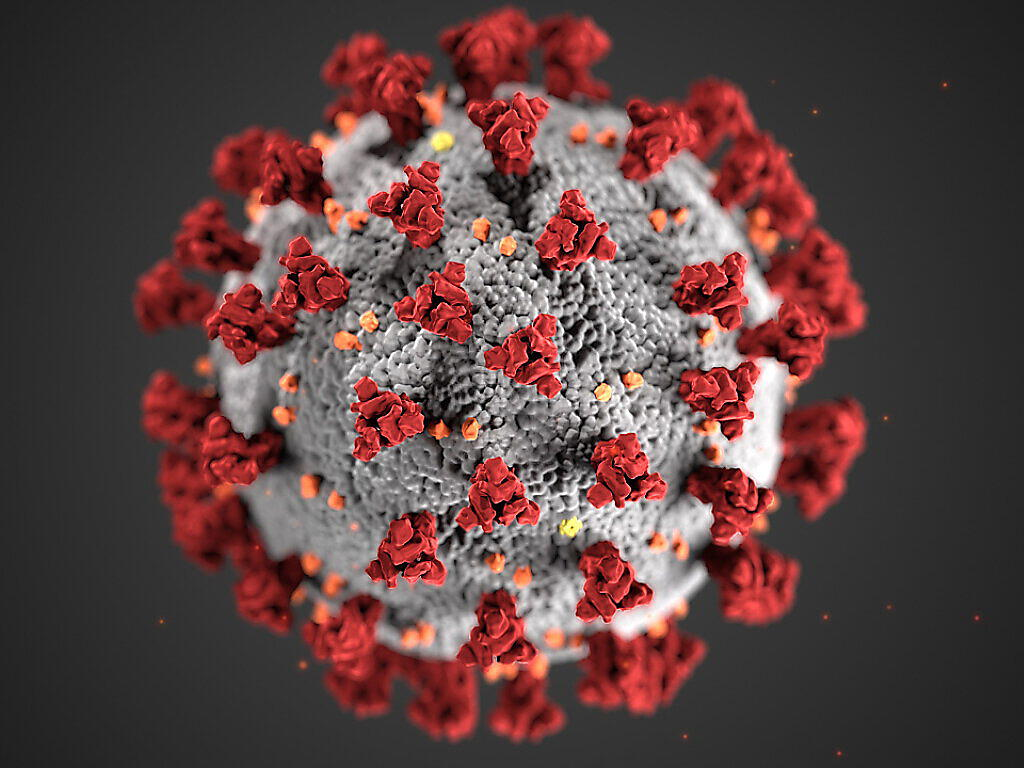

In [1]:
from IPython.display import Image

# Set PATH here that points at the Covid19 folder
PATH = "/Users/giacomomiolo/Downloads/Covid19/"
Image(PATH + "sars-cov-19.jpg")

# Importing Libraries and Datasets

In [2]:
import pandas as pd
import numpy as np


import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import plotly.subplots as sub
pio.templates.default = 'plotly_dark'
from matplotlib.cbook import boxplot_stats
import datetime
from datetime import datetime
from scipy.integrate import odeint
from scipy import optimize 
from scipy.optimize import least_squares, leastsq
from sklearn import metrics 
from sklearn.model_selection import train_test_split
import scipy
from geopy.geocoders import Nominatim
import pycountry_convert as pc

import warnings
warnings.filterwarnings("ignore")

### Reproducibility

In [3]:
!python --version

Python 3.7.6


In [4]:
!jupyter --version

jupyter core     : 4.6.3
jupyter-notebook : 6.0.3
qtconsole        : 4.7.1
ipython          : 7.13.0
ipykernel        : 5.2.0
jupyter client   : 6.1.0
jupyter lab      : 2.0.1
nbconvert        : 5.6.1
ipywidgets       : 7.5.1
nbformat         : 5.0.4
traitlets        : 4.3.3


In [5]:
!jupyter labextension list

JupyterLab v2.0.1
Known labextensions:
   app dir: /Users/giacomomiolo/opt/anaconda3/share/jupyter/lab
        @jupyter-widgets/jupyterlab-manager v2.0.0  enabled  OK
        @jupyterlab/toc v3.0.0  enabled  OK
        ipyvolume v0.5.2  enabled  OK
        jupyter-threejs v2.2.0  enabled  OK
        jupyterlab-datawidgets v6.2.0  enabled  OK
        jupyterlab-plotly v1.5.4  enabled  OK
        keplergl-jupyter v0.1.2  enabled  OK
        plotlywidget v1.5.4  enabled  OK

Uninstalled core extensions:
    jupyter-threejs
    keplergl-jupyter


In [6]:
import pkg_resources
import types
def get_imports():
    '''This function prints all the packages used in this notebook and their version.'''
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            name = val.__name__.split(".")[0]
        elif isinstance(val, type):
            name = val.__module__.split(".")[0]
        poorly_named_packages = {"sklearn": "scikit-learn"}
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]
        yield name
imports = [*set(get_imports())]

requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

for r in requirements:
    print(f"{r[0]} {r[1]}")

seaborn 0.10.0
scipy 1.4.1
scikit-learn 0.22.2
plotly 4.5.4
pandas 1.0.3
numpy 1.17.2
matplotlib 3.2.1
geopy 1.21.0


### Importing Datasets

In [7]:
# Original dataset provided
df = pd.read_csv(PATH + "covid_19_data.csv", index_col=0)

In [8]:
# Additional datasets

# Kaggle Competition Week 4

test = pd.read_csv(PATH + "covid19-global-forecasting-week-4/test.csv", index_col=0)
train = pd.read_csv(PATH + "covid19-global-forecasting-week-4/train.csv", index_col=0)

## Helper Functions

### Decorators

In [9]:
from functools import wraps
import timeit
from timeit import default_timer


def timer(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        start_time = timeit.default_timer()
        try:
            result = func(*args, **kwargs)
        finally:
            elapsed = timeit.default_timer() - start_time
        print(f'Function {func.__name__} took {elapsed*1000:0.4f} ms to complete.')
        return result
    return wrapper


def print_return_type(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        try:
            result = func(*args, **kwargs)
        finally:
            print(f'Function {func.__name__} returned type {type(result)}.')
            return result
    return wrapper

In [10]:
import re

def clean_str(string):
    '''
    Removes special characters and double spaces from a string, preserving single spaces between words.
    
    Args:
        string (str): the dirty string to clean.
    
    Returns:
        cleaned (str)
    '''
    non_word_digit = re.compile(r"[^a-zA-Z0-9 ]+") # Leaving spaces, removing all non letter/digit (add \- to leave - char as well)
    multiple_spaces = re.compile(r"( {2,})") # Catching all repeated spaces
    start_end_spaces = re.compile(r"(\A\s|\s\Z)") # Removing spaces at start/end
    step_1 = re.sub(non_word_digit, "", string)
    step_2 = re.sub(multiple_spaces, " ", step_1)
    cleaned = re.sub(start_end_spaces, "", step_2)
    
    return cleaned

In [11]:
@timer
def describe_col(df, col):
    
    '''Takes as input a dataframe and the name of the column you want to describe.
    Returns the unique values, eventual missing values count,
    the absolute frequencies and the relative frequencies of unique values.'''
    
    # Number, count and percentage of unique values in the column
    print(f'{col} - {df[col].nunique()} unique values.')
    count = df[col].value_counts(sort=True, dropna=True)
    perc = df[col].value_counts(normalize=True, sort=True, ascending=False, dropna=True)*100
    d = pd.concat([perc, count], axis=1, keys=['Percentage %', 'Count'])
    
    # dtype of the column
    print(f"dtype: {df[col].dtype}.")
    
    # Number of missing values, if any
    missing_count = df[col].isnull().sum()
    if missing_count != 0:
        total = len(df[col])
        missing_perc = (missing_count/total)*100
        
        print(f'! Missing values: perc - {missing_perc:0.3f}% count - {missing_count}')
    else:
        print(f'No missing values.\n')
    

    return print(d)

# Exploratory Data Analysis

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7926 entries, 1 to 7926
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ObservationDate  7926 non-null   object 
 1   Province/State   4493 non-null   object 
 2   Country/Region   7926 non-null   object 
 3   Last Update      7926 non-null   object 
 4   Confirmed        7926 non-null   float64
 5   Deaths           7926 non-null   float64
 6   Recovered        7926 non-null   float64
dtypes: float64(3), object(4)
memory usage: 495.4+ KB


In [13]:
df.head()

ObservationDate Province/State  Country/Region      Last Update  \
SNo                                                                   
1        01/22/2020          Anhui  Mainland China  1/22/2020 17:00   
2        01/22/2020        Beijing  Mainland China  1/22/2020 17:00   
3        01/22/2020      Chongqing  Mainland China  1/22/2020 17:00   
4        01/22/2020         Fujian  Mainland China  1/22/2020 17:00   
5        01/22/2020          Gansu  Mainland China  1/22/2020 17:00   

     Confirmed  Deaths  Recovered  
SNo                                
1          1.0     0.0        0.0  
2         14.0     0.0        0.0  
3          6.0     0.0        0.0  
4          1.0     0.0        0.0  
5          0.0     0.0        0.0

In [14]:
train.head()

Province_State Country_Region        Date  ConfirmedCases  Fatalities
Id                                                                      
1             NaN    Afghanistan  2020-01-22             0.0         0.0
2             NaN    Afghanistan  2020-01-23             0.0         0.0
3             NaN    Afghanistan  2020-01-24             0.0         0.0
4             NaN    Afghanistan  2020-01-25             0.0         0.0
5             NaN    Afghanistan  2020-01-26             0.0         0.0

In [15]:
pd.DataFrame([df.isna().sum().values,
              np.round(df.isna().sum().values/len(df)*100,0)], index=['Count','Percentage'], columns=df.columns).transpose()

Count  Percentage
ObservationDate     0.0         0.0
Province/State   3433.0        43.0
Country/Region      0.0         0.0
Last Update         0.0         0.0
Confirmed           0.0         0.0
Deaths              0.0         0.0
Recovered           0.0         0.0

In [16]:
# Renaming following Kaggle Competition Covid-19 forecast naming conventions
df.columns = ['Date',
              'Province_State',
              'Country_Region',
              'Last Update',
              'ConfirmedCases',
              'Fatalities',
              'Recovered']

In [17]:
df.head()

Date Province_State  Country_Region      Last Update  \
SNo                                                               
1    01/22/2020          Anhui  Mainland China  1/22/2020 17:00   
2    01/22/2020        Beijing  Mainland China  1/22/2020 17:00   
3    01/22/2020      Chongqing  Mainland China  1/22/2020 17:00   
4    01/22/2020         Fujian  Mainland China  1/22/2020 17:00   
5    01/22/2020          Gansu  Mainland China  1/22/2020 17:00   

     ConfirmedCases  Fatalities  Recovered  
SNo                                         
1               1.0         0.0        0.0  
2              14.0         0.0        0.0  
3               6.0         0.0        0.0  
4               1.0         0.0        0.0  
5               0.0         0.0        0.0

### Converting to datetime format

In [18]:
# Given Dataset
df['Date'] =  pd.to_datetime(df['Date'])
df['Last Update'] =  pd.to_datetime(df['Last Update'])

# Kaggle Dataset Week 4
train['Date'] =  pd.to_datetime(train['Date'])

In [19]:
# Given Dataset
sorted_lastupdate = np.sort(df['Last Update'])
timedelta_ns = sorted_lastupdate[-1] - sorted_lastupdate[0]
timedelta_days = timedelta_ns.astype('timedelta64[D]')
print(f"Time interval considered for Last Update: {timedelta_days.item().days} days.")

Time interval considered for Last Update: 60 days.


In [20]:
# Given Dataset
sorted_obsdate = np.sort(df['Date'])
timedelta_ns = sorted_obsdate[-1] - sorted_obsdate[0]
timedelta_days = timedelta_ns.astype('timedelta64[D]')
print(f"Time interval considered for Date, Given Dataset: {timedelta_days.item().days} days.\n\
First observation: {np.datetime_as_string(sorted_obsdate[1], unit='D')}\n\
Last observation: {np.datetime_as_string(sorted_obsdate[-1], unit='D')}\n")

# Kaggle Dataset Week 4
sorted_obsdate = np.sort(train['Date'])
timedelta_ns = sorted_obsdate[-1] - sorted_obsdate[0]
timedelta_days = timedelta_ns.astype('timedelta64[D]')
print(f"Time interval considered for Date, Kaggle Dataset: {timedelta_days.item().days} days.\n\
First observation: {np.datetime_as_string(sorted_obsdate[1], unit='D')}\n\
Last observation: {np.datetime_as_string(sorted_obsdate[-1], unit='D')}\n")

Time interval considered for Date, Given Dataset: 60 days.
First observation: 2020-01-22
Last observation: 2020-03-22

Time interval considered for Date, Kaggle Dataset: 81 days.
First observation: 2020-01-22
Last observation: 2020-04-12



### Cleaning Country_Region column

In [21]:
# Given Dataset
country_array = df['Country_Region'].to_numpy()
np_clean_str = np.frompyfunc(clean_str, 1, 1)
df['Country_Region'] = np_clean_str(country_array)

# Kaggle
country_array_k = train['Country_Region'].to_numpy()
train['Country_Region'] = np_clean_str(country_array_k)

In [22]:
country_dict = {
    'St Martin' : 'Saint Martin',
    'occupied Palestinian territory' : 'Palestine',
    'Congo Kinshasa' : 'Democratic Republic of the Congo',
    'Congo Brazzaville' : 'Republic of the Congo',
    'Gambia The' : 'Gambia',
    'The Gambia' : 'Gambia',
    'Bahamas The' : 'Bahamas',
    'The Bahamas' : 'Bahamas',
    'Cabo Verde' : 'Cape Verde',
    'TimorLeste' : 'East Timor',
    'Holy See' : 'Vatican City',
    'Mainland China' : 'China',
    'The Bahamas' : 'Bahamas',
    'UK' : 'United Kingdom',
    'US' : 'USA',
    'Niger' : 'Nigeria',
    'Ireland' : 'Republic of Ireland'
}

df['Country_Region'].replace(country_dict, inplace=True)
train['Country_Region'].replace(country_dict, inplace=True)

In [23]:
country_list = [*df['Country_Region'].unique()]

### Worldwide COVID-19 situation

In [24]:
# Given Dataset
total = df.groupby("Date").sum()

# Kaggle Dataset Week 4
total_k = train.groupby("Date").sum()

In [25]:
# Given Dataset
total["Active Cases"] = total["ConfirmedCases"] - total["Fatalities"] - total["Recovered"]

data = ["ConfirmedCases", "Fatalities", "Recovered", "Active Cases"]
total[data] = total[data].astype(np.int64)


total["Case Fatality Rate %"] = total["Fatalities"] / total["ConfirmedCases"] * 100
total["Case Recovery Rate %"] = total["Recovered"] / total["ConfirmedCases"] * 100

# Kaggle Dataset Week 4
data_k = ["ConfirmedCases", "Fatalities"]
# 
total_k[data_k] = total_k[data_k].astype(np.int64)
total_k["Case Fatality Rate %"] = total_k["Fatalities"] / total_k["ConfirmedCases"] * 100
w = total_k.drop(['Fatalities'], axis=1)

In [26]:
total.tail()

ConfirmedCases  Fatalities  Recovered  Active Cases  \
Date                                                              
2020-03-18          214915        8733      83313        122869   
2020-03-19          242713        9867      84962        147884   
2020-03-20          272167       11299      87403        173465   
2020-03-21          304528       12973      91676        199879   
2020-03-22          335957       14634      97882        223441   

            Case Fatality Rate %  Case Recovery Rate %  
Date                                                    
2020-03-18              4.063467             38.765558  
2020-03-19              4.065295             35.005130  
2020-03-20              4.151495             32.113739  
2020-03-21              4.260035             30.104293  
2020-03-22              4.355915             29.135276

In [27]:
total_k.tail()

ConfirmedCases  Fatalities  Case Fatality Rate %
Date                                                        
2020-04-08         1510928       88332              5.846208
2020-04-09         1595174       95449              5.983611
2020-04-10         1691542      102519              6.060683
2020-04-11         1771337      108497              6.125147
2020-04-12         1846503      114088              6.178598

#### Grouping by Country and Date

In [28]:
# Given Dataset
country_g = df.groupby(["Country_Region", "Date"]).sum()

# Kaggle Dataset Week 4
country_k = train.groupby(["Country_Region", "Date"]).sum()

countries = [*country_k.index.get_level_values(0).unique()]

In [29]:
country_g.head()

ConfirmedCases  Fatalities  Recovered
Country_Region Date                                             
Afghanistan    2020-02-24             1.0         0.0        0.0
               2020-02-25             1.0         0.0        0.0
               2020-02-26             1.0         0.0        0.0
               2020-02-27             1.0         0.0        0.0
               2020-02-28             1.0         0.0        0.0

### Case Fatality/Recovery Rate

In [30]:
# CASE FATALITY RATE
from collections import OrderedDict

def get_cfr(country):
    '''
    Arguments:
        country (str): Name of the country
    Returns:
        country_df (pandas.core.frame.DataFrame): Df of the country
    '''
    country_mask = country_k.index.get_level_values(0) == country
    country_df = country_k[country_mask]
    country_df.index = country_df.index.droplevel(0)
    zero_deaths_mask = country_df['Fatalities'] != 0
    country_df = country_df[zero_deaths_mask]
    country_df["Case Fatality Rate %"] = country_df["Fatalities"] / country_df["ConfirmedCases"] * 100
    return country_df


skipped_countries = []
country_cfr = OrderedDict()

for country in countries:
    country_df = get_cfr(country)
    max_cfr = 0
    try:
        if country_df['ConfirmedCases'][-1] > 5000:
            country_cfr[country] = country_df['Case Fatality Rate %'][-1]
    except:
        skipped_countries.append(country)
sorted(country_cfr.items(), key=lambda x: x[1], reverse=True)

[('Italy', 12.726156443659944),
 ('United Kingdom', 12.474473628617703),
 ('Belgium', 12.142881235875468),
 ('France', 10.781776015560709),
 ('Netherlands', 10.669618581527228),
 ('Spain', 10.315229184024552),
 ('Sweden', 8.57578937327101),
 ('Iran', 6.241107050191111),
 ('Brazil', 5.510994953136265),
 ('Romania', 5.015873015873016),
 ('Ecuador', 4.460219662469863),
 ('Switzerland', 4.351760771198111),
 ('Denmark', 4.286387187941592),
 ('China', 4.021218755262588),
 ('USA', 3.96613527875349),
 ('India', 3.5958718087995654),
 ('Poland', 3.4761762061732093),
 ('Republic of Ireland', 3.4593474883480058),
 ('Portugal', 3.038890563762436),
 ('Canada', 2.9358478135551347),
 ('Peru', 2.5668306955712197),
 ('Austria', 2.509860164933668),
 ('Germany', 2.3636335194831606),
 ('Czechia', 2.303455182774161),
 ('Turkey', 2.1033780462111107),
 ('Korea South', 2.0357686453576864),
 ('Norway', 1.9616858237547892),
 ('Pakistan', 1.7399617590822178),
 ('Japan', 1.6004742145820983),
 ('Chile', 1.109108553

In [31]:
# CASE RECOVERY RATE
def get_crr(country):
    '''
    Arguments:
        country (str): Name of the country
    Returns:
        country_df (pandas.core.frame.DataFrame): Df of the country
    '''
    country_mask = country_g.index.get_level_values(0) == country
    country_df = country_g[country_mask]
    country_df.index = country_df.index.droplevel(0)
    zero_recovered_mask = country_df['Recovered'] != 0
    country_df = country_df[zero_recovered_mask]
    country_df["Case Recovery Rate %"] = country_df["Recovered"] / country_df["ConfirmedCases"] * 100
    return country_df




skipped_countries = []
country_crr = OrderedDict()

for country in countries:
    country_df = get_crr(country)
    max_crr = 0
    try:
        if country_df['ConfirmedCases'][-1] > 1000:
            country_crr[country] = country_df['Case Recovery Rate %'][-1]
    except:
        skipped_countries.append(country)
sorted(country_crr.items(), key=lambda x: x[1], reverse=True)

[('China', 89.13397483345669),
 ('Iran', 36.653110268971254),
 ('Japan', 21.639042357274402),
 ('France', 13.712291199202195),
 ('Italy', 11.877303933173256),
 ('Malaysia', 10.643185298621747),
 ('Spain', 8.950917686318132),
 ('Belgium', 7.733019700088209),
 ('Australia', 6.69710806697108),
 ('Israel', 3.454715219421102),
 ('Switzerland', 1.808143547273982),
 ('United Kingdom', 1.16704406897753),
 ('Germany', 1.069432718208499),
 ('Sweden', 0.8273009307135472),
 ('Canada', 0.6825938566552902),
 ('USA', 0.5349200625075129),
 ('Portugal', 0.3125),
 ('Austria', 0.27743526510480887),
 ('Brazil', 0.12554927809165098),
 ('Denmark', 0.06605019815059446),
 ('Netherlands', 0.04743833017077799),
 ('Norway', 0.0419639110365086)]

In [32]:
# FATALITY RATE
it = get_cfr('Italy')
uk = get_cfr('United Kingdom')
be = get_cfr('Belgium')
fr = get_cfr('France')
nl = get_cfr('Netherlands')
sp = get_cfr('Spain')
sw = get_cfr('Sweden')

# RECOVERY RATE
ch = get_crr('China')
ir = get_crr('Iran')
jp = get_crr('Japan')
fr_r = get_crr('France')
it_r = get_crr('Italy')

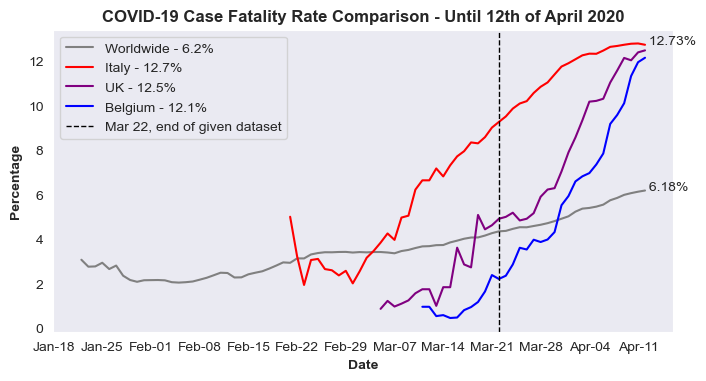

In [33]:
# Comparison Fatality Rate
import matplotlib.dates as mdates


sns.set_style("dark")

data = ["ConfirmedCases", "Fatalities", "Recovered", "Infected"]

fig, ax = plt.subplots(figsize=(8, 4), dpi=100)
ax.plot(total_k.index, total_k["Case Fatality Rate %"], linestyle='-', marker='', label=f"Worldwide - {total_k['Case Fatality Rate %'][-1]:0.1f}%", color = "grey")
ax.plot(it.index, it["Case Fatality Rate %"], linestyle='-', marker='', label=f"Italy - {it['Case Fatality Rate %'][-1]:0.1f}%", color = "red")
ax.plot(uk.index, uk["Case Fatality Rate %"], linestyle='-', marker='', label=f"UK - {uk['Case Fatality Rate %'][-1]:0.1f}%", color = "purple")
ax.plot(be.index, be["Case Fatality Rate %"], linestyle='-', marker='', label=f"Belgium - {be['Case Fatality Rate %'][-1]:0.1f}%", color = "blue")

ax.set_xlabel("Date", fontweight='bold')
ax.set_ylabel("Percentage", fontweight='bold')

# Showing tick every week
days = mdates.DayLocator(interval=7)
days_format = mdates.DateFormatter('%b-%d')
ax.xaxis.set_major_locator(days)
ax.xaxis.set_major_formatter(days_format)
plt.setp(ax.get_xticklabels(), rotation=0)

ax.axvline(pd.to_datetime('2020-03-22'), color='black', linestyle='--', label='Mar 22, end of given dataset', lw=1)



ax.annotate(
    f" {total_k['Case Fatality Rate %'][-1]:0.2f}%",
    xy=(total_k.index[-1], total_k['Case Fatality Rate %'][-1]))

ax.annotate(
    f" {it['Case Fatality Rate %'][-1]:0.2f}%",
    xy=(it.index[-1], it['Case Fatality Rate %'][-1]))

plt.title("COVID-19 Case Fatality Rate Comparison - Until 12th of April 2020", fontweight='bold')
plt.legend()
plt.savefig('CFR Comparison.png')
plt.show()

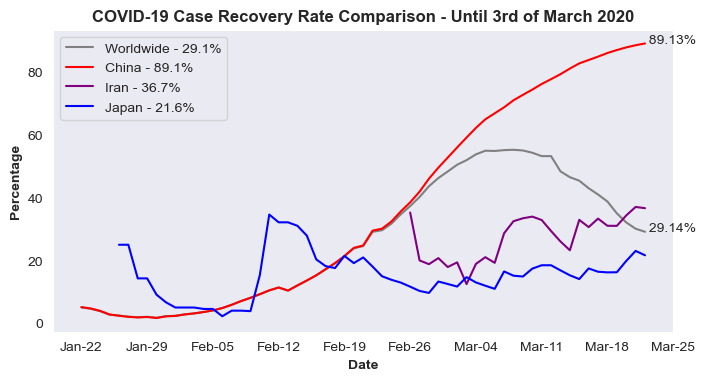

In [34]:
# Comparison Fatality Rate


fig, ax = plt.subplots(figsize=(8, 4), dpi=100)
ax.plot(total.index, total["Case Recovery Rate %"], linestyle='-', marker='', label=f"Worldwide - {total['Case Recovery Rate %'][-1]:0.1f}%", color = "grey")
ax.plot(ch.index, ch["Case Recovery Rate %"], linestyle='-', marker='', label=f"China - {ch['Case Recovery Rate %'][-1]:0.1f}%", color = "red")
ax.plot(ir.index, ir["Case Recovery Rate %"], linestyle='-', marker='', label=f"Iran - {ir['Case Recovery Rate %'][-1]:0.1f}%", color = "purple")
ax.plot(jp.index, jp["Case Recovery Rate %"], linestyle='-', marker='', label=f"Japan - {jp['Case Recovery Rate %'][-1]:0.1f}%", color = "blue")

ax.set_xlabel("Date", fontweight='bold')
ax.set_ylabel("Percentage", fontweight='bold')

# Showing tick every week
days = mdates.DayLocator(interval=7)
days_format = mdates.DateFormatter('%b-%d')
ax.xaxis.set_major_locator(days)
ax.xaxis.set_major_formatter(days_format)
plt.setp(ax.get_xticklabels(), rotation=0)

# ax.axvline(pd.to_datetime('2020-03-22'), color='black', linestyle='--', label='Mar 22, end of given dataset', lw=1)



ax.annotate(
    f" {total['Case Recovery Rate %'][-1]:0.2f}%",
    xy=(total.index[-1], total['Case Recovery Rate %'][-1]))

ax.annotate(
    f" {ch['Case Recovery Rate %'][-1]:0.2f}%",
    xy=(ch.index[-1], ch['Case Recovery Rate %'][-1]))

# ax.annotate(
#     f" {uk['Case Fatality Rate %'][-1]:0.2f}%",
#     xy=(uk.index[-1], uk['Case Fatality Rate %'][-1]))
# 
# ax.annotate(
#     f" {be['Case Fatality Rate %'][-1]:0.2f}%",
#     xy=(be.index[-1], be['Case Fatality Rate %'][-1]))

plt.title("COVID-19 Case Recovery Rate Comparison - Until 3rd of March 2020", fontweight='bold')
plt.legend()
plt.savefig('CRR Comparison.png')
plt.show()

#### Number of tests

In [35]:
tests = pd.read_csv(PATH + "full-list-cumulative-total-tests-per-thousand.csv")

In [36]:
describe_col(tests, 'Entity')

Entity - 67 unique values.
dtype: object.
No missing values.

                                       Percentage %  Count
United Kingdom                             3.752860     82
South Korea                                3.707094     81
United States, specimens tested (CDC)      3.661327     80
Israel                                     3.340961     73
Czech Republic                             3.340961     73
...                                             ...    ...
Hong Kong                                  0.183066      4
Philippines                                0.137300      3
El Salvador                                0.091533      2
Singapore, swabs tested                    0.045767      1
Singapore                                  0.045767      1

[67 rows x 2 columns]
Function describe_col took 36.7533 ms to complete.


In [37]:
tests['Date'] =  pd.to_datetime(tests['Date'])

In [38]:
tests_date = tests.groupby('Date').sum()
tests_date.tail()

Total tests per thousand
Date                                
2020-04-11                   518.493
2020-04-12                   549.896
2020-04-13                   395.254
2020-04-14                   571.144
2020-04-15                   386.857

In [39]:
it_mask = tests['Entity'] == 'Italy'
sk_mask = tests['Entity'] == 'South Korea'
usa_mask = tests['Entity'] == 'United States'
tests_it = tests[it_mask]
tests_sk = tests[sk_mask]
tests_usa = tests[usa_mask]


tests_sk.tail()

Entity Code       Date  Total tests per thousand
1764  South Korea  KOR 2020-04-11                     9.911
1765  South Korea  KOR 2020-04-12                     9.991
1766  South Korea  KOR 2020-04-13                    10.071
1767  South Korea  KOR 2020-04-14                    10.240
1768  South Korea  KOR 2020-04-15                    10.378

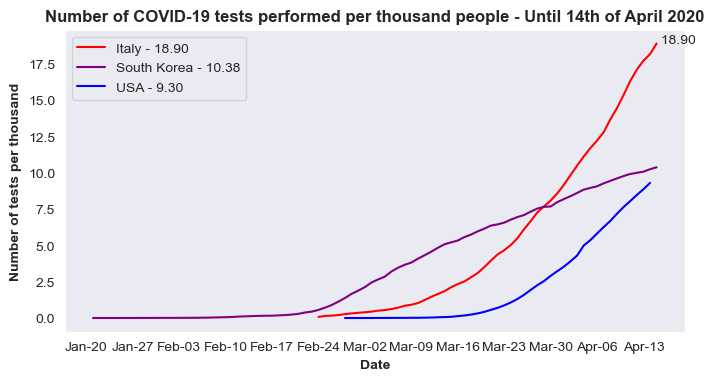

In [40]:
fig, ax = plt.subplots(figsize=(8, 4), dpi=100)
ax.plot(tests_it['Date'], tests_it['Total tests per thousand'], linestyle='-', marker='', label=f"Italy - {tests_it['Total tests per thousand'].iloc[-1]:0.2f}", color = "red")
ax.plot(tests_sk['Date'], tests_sk['Total tests per thousand'], linestyle='-', marker='', label=f"South Korea - {tests_sk['Total tests per thousand'].iloc[-1]:0.2f}", color = "purple")
ax.plot(tests_usa['Date'], tests_usa['Total tests per thousand'], linestyle='-', marker='', label=f"USA - {tests_usa['Total tests per thousand'].iloc[-1]:0.2f}", color = "blue")

ax.set_xlabel("Date", fontweight='bold')
ax.set_ylabel("Number of tests per thousand", fontweight='bold')

# Showing tick every week
days = mdates.DayLocator(interval=7)
days_format = mdates.DateFormatter('%b-%d')
ax.xaxis.set_major_locator(days)
ax.xaxis.set_major_formatter(days_format)
plt.setp(ax.get_xticklabels(), rotation=0)

# ax.axvline(pd.to_datetime('2020-03-22'), color='black', linestyle='--', label='Mar 22, end of given dataset', lw=1)



ax.annotate(
    f" {tests_it['Total tests per thousand'].iloc[-1]:0.2f}",
    xy=(tests_it['Date'].iloc[-1], tests_it['Total tests per thousand'].iloc[-1]))

#ax.annotate(
#    f" {ch['Case Recovery Rate %'][-1]:0.2f}%",
#    xy=(ch.index[-1], ch['Case Recovery Rate %'][-1]))
#
# ax.annotate(
#     f" {uk['Case Fatality Rate %'][-1]:0.2f}%",
#     xy=(uk.index[-1], uk['Case Fatality Rate %'][-1]))
# 
# ax.annotate(
#     f" {be['Case Fatality Rate %'][-1]:0.2f}%",
#     xy=(be.index[-1], be['Case Fatality Rate %'][-1]))

plt.title("Number of COVID-19 tests performed per thousand people - Until 14th of April 2020", fontweight='bold')
plt.legend()
plt.savefig('TestsCOVID.png')
plt.show()

### Situation per country from March 1st onwards - Interactive Graph

In [41]:
reindexed_k = country_k.reset_index()
march_onwards = reindexed_k['Date']>='2020-03-01'
reindexed_k = reindexed_k[march_onwards]
reindexed_k['Date'] = reindexed_k['Date'].astype(str)
reindexed_k.head()

Country_Region        Date  ConfirmedCases  Fatalities
39    Afghanistan  2020-03-01             1.0         0.0
40    Afghanistan  2020-03-02             1.0         0.0
41    Afghanistan  2020-03-03             1.0         0.0
42    Afghanistan  2020-03-04             1.0         0.0
43    Afghanistan  2020-03-05             1.0         0.0

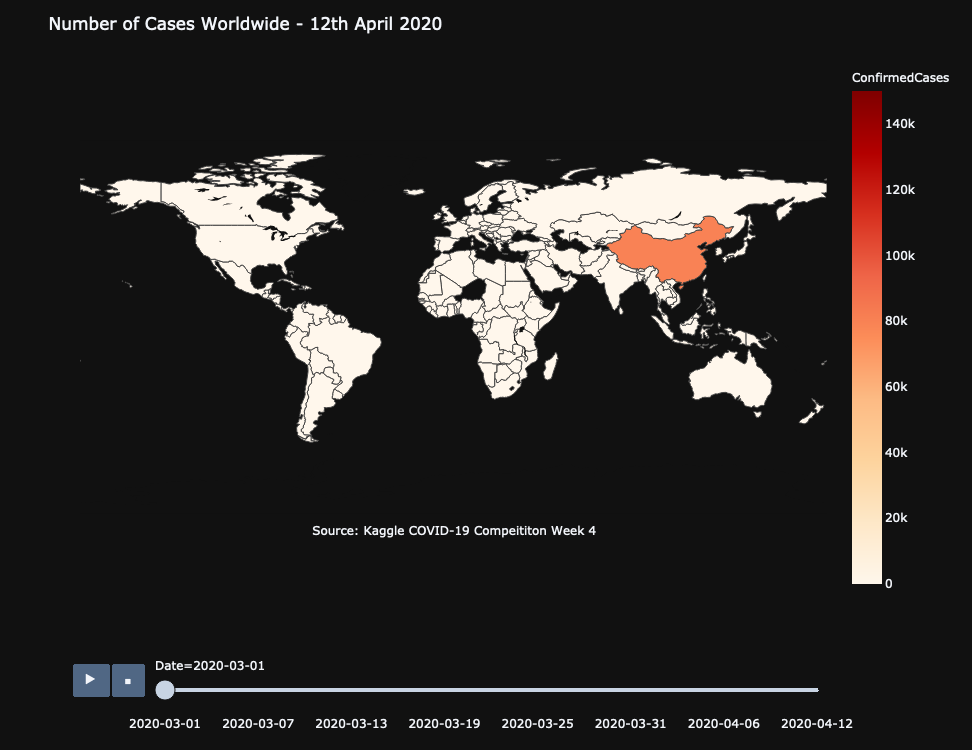

In [42]:
fig = px.choropleth(reindexed_k,
                    locations="Country_Region",
                    locationmode='country names',
                    color="ConfirmedCases",
                    range_color=[0,150000],
                    color_continuous_scale=px.colors.sequential.OrRd,
                    hover_name="Country_Region",
                    animation_frame="Date",
                    height=750)

fig.update_layout(
    title_text='Number of Cases Worldwide - 12th April 2020',
    geo=dict(
        showframe=False,
        showcoastlines=False,
        projection_type='equirectangular'
    ),
    annotations = [dict(
        x=0.50,
        y=0.10,
        xref='paper',
        yref='paper',
        text='Source: <a href="https://www.kaggle.com/c/covid19-global-forecasting-week-4/">Kaggle COVID-19 Compeititon Week 4</a>',
        showarrow = False
    )]
)

fig.show()

### Situation as of March 22nd vs. April 12th

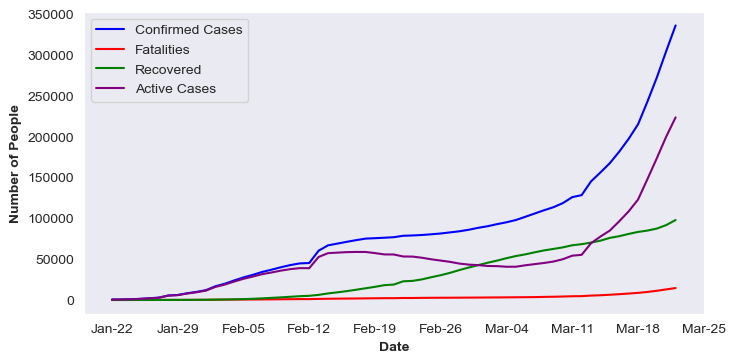

In [43]:
sns.set_style("dark")

data = ["ConfirmedCases", "Fatalities", "Recovered", "Infected"]

fig, ax = plt.subplots(figsize=(8, 4), dpi=100)
ax.plot(total.index, total["ConfirmedCases"], linestyle='-', marker='', label="Confirmed Cases", color = "blue")
ax.plot(total.index, total["Fatalities"], linestyle='-', marker='', label="Fatalities", color = "red") 
ax.plot(total.index, total["Recovered"], linestyle='-', marker='', label="Recovered", color = "green")
ax.plot(total.index, total["Active Cases"], linestyle='-', marker='', label="Active Cases", color = "purple")

plt.legend()
ax.set_xlabel("Date", fontweight='bold')
ax.set_ylabel("Number of People", fontweight='bold')

# Showing tick every week
days = mdates.DayLocator(interval=7)
days_format = mdates.DateFormatter('%b-%d')
ax.xaxis.set_major_locator(days)
ax.xaxis.set_major_formatter(days_format)
plt.setp(ax.get_xticklabels(), rotation=0)

plt.savefig("Active.png")
plt.show()


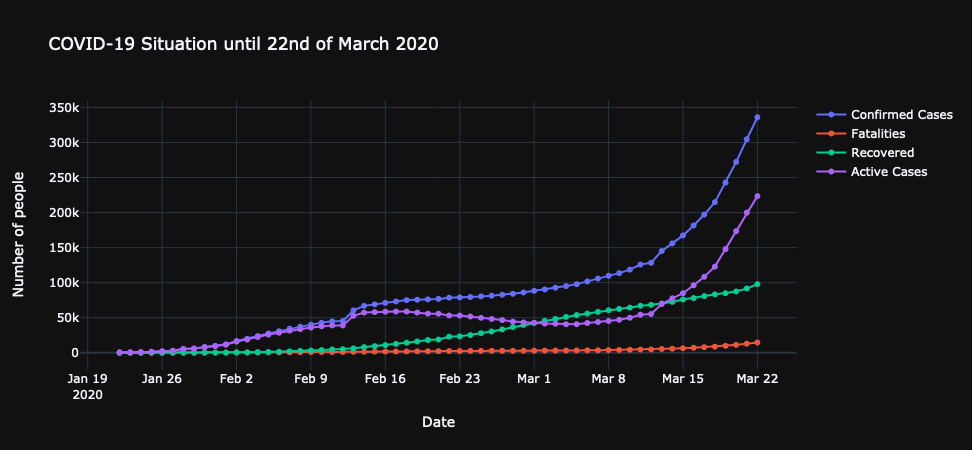

In [44]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=total.index, y=total['ConfirmedCases'],
                    mode='lines+markers',
                    name='Confirmed Cases'))

fig.add_trace(go.Scatter(x=total.index, y=total['Fatalities'],
                    mode='lines+markers',
                    name='Fatalities'))

fig.add_trace(go.Scatter(x=total.index, y=total['Recovered'],
                    mode='lines+markers',
                    name='Recovered'))

fig.add_trace(go.Scatter(x=total.index, y=total['Active Cases'],
                    mode='lines+markers',
                    name='Active Cases'))


fig.update_layout(
    title_text="COVID-19 Situation until 22nd of March 2020",
    showlegend=True,
    xaxis_title="Date",
    yaxis_title="Number of people"
)

fig.show()


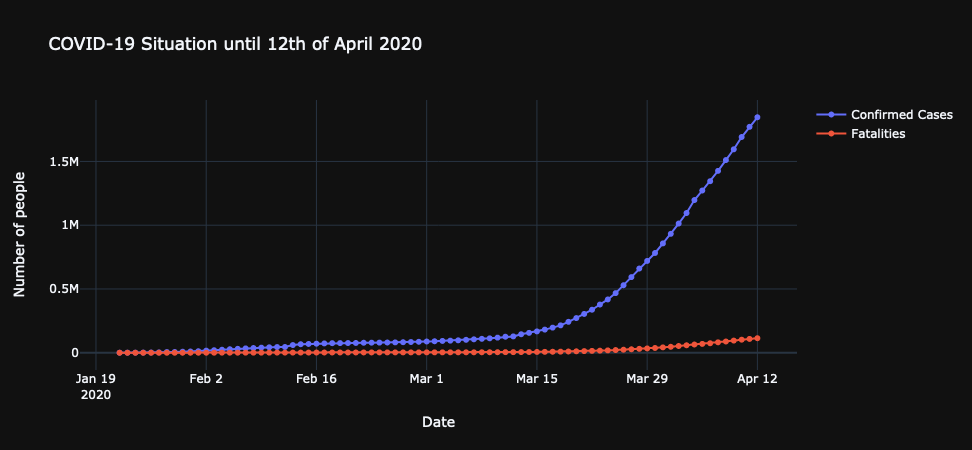

In [45]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=total_k.index, y=total_k['ConfirmedCases'],
                    mode='lines+markers',
                    name='Confirmed Cases'))

fig.add_trace(go.Scatter(x=total_k.index, y=total_k['Fatalities'],
                    mode='lines+markers',
                    name='Fatalities'))

fig.update_layout(
    title_text="COVID-19 Situation until 12th of April 2020",
    showlegend=True,
    xaxis_title="Date",
    yaxis_title="Number of people"
)

fig.show()


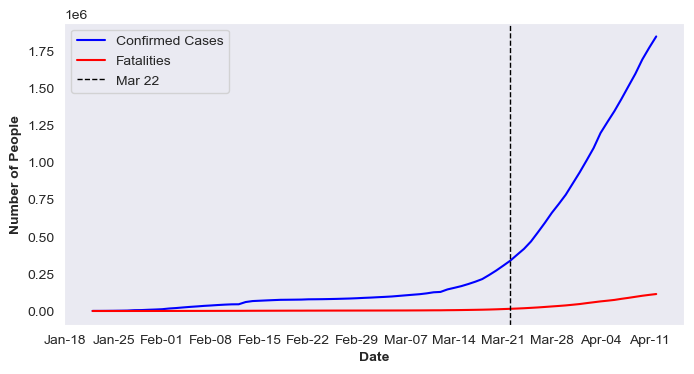

In [46]:
# Comparison
import matplotlib.dates as mdates


sns.set_style("dark")


fig, ax = plt.subplots(figsize=(8, 4), dpi=100)
ax.plot(total_k.index, total_k["ConfirmedCases"], linestyle='-', marker='', label="Confirmed Cases", color = "blue")
ax.plot(total_k.index, total_k["Fatalities"], linestyle='-', marker='', label="Fatalities", color = "red") 

ax.set_xlabel("Date", fontweight='bold')
ax.set_ylabel("Number of People", fontweight='bold')

# Showing tick every week
days = mdates.DayLocator(interval=7)
days_format = mdates.DateFormatter('%b-%d')
ax.xaxis.set_major_locator(days)
ax.xaxis.set_major_formatter(days_format)
plt.setp(ax.get_xticklabels(), rotation=0)

ax.axvline(pd.to_datetime('2020-03-22'), color='black', linestyle='--', label='Mar 22', lw=1)
plt.legend()
plt.savefig('Integration.png')
plt.show()



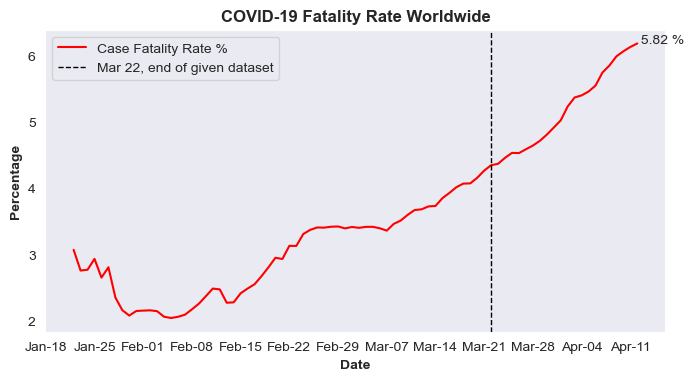

In [47]:
# Comparison
import matplotlib.dates as mdates


sns.set_style("dark")

data = ["ConfirmedCases", "Fatalities", "Recovered", "Infected"]

fig, ax = plt.subplots(figsize=(8, 4), dpi=100)
ax.plot(total_k.index, total_k["Case Fatality Rate %"], linestyle='-', marker='', label="Case Fatality Rate %", color = "red")

ax.set_xlabel("Date", fontweight='bold')
ax.set_ylabel("Percentage", fontweight='bold')

# Showing tick every week
days = mdates.DayLocator(interval=7)
days_format = mdates.DateFormatter('%b-%d')
ax.xaxis.set_major_locator(days)
ax.xaxis.set_major_formatter(days_format)
plt.setp(ax.get_xticklabels(), rotation=0)

ax.axvline(pd.to_datetime('2020-03-22'), color='black', linestyle='--', label='Mar 22, end of given dataset', lw=1)



ax.annotate(
    " 5.82 %",
    xy=(total_k.index[-1], total_k['Case Fatality Rate %'][-1]))

plt.title("COVID-19 Fatality Rate Worldwide", fontweight='bold')
plt.legend()
plt.show()

In [48]:
# data_cols = ["Infected", "Deaths", "Recovered"]
# data_cols_all = ["Confirmed", "Infected", "Deaths", "Recovered"]
# rate_cols = ["Fatal per Confirmed", "Recovered per Confirmed", "Fatal per (Fatal or Recovered)"]
# df["Date"] = pd.to_datetime(df["Date"])
# df["Infected"] = df["Confirmed"] - df["Deaths"] - df["Recovered"]
# df[data_cols_all] = df[data_cols_all].astype(np.int64)

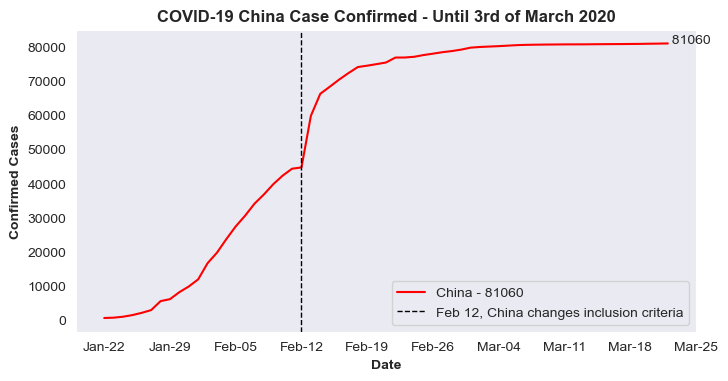

In [49]:
fig, ax = plt.subplots(figsize=(8, 4), dpi=100)
# ax.plot(total_k.index, total_k["ConfirmedCases"], linestyle='-', marker='', label=f"Worldwide - {total_k['ConfirmedCases'][-1]:0.1f}", color = "grey")
ax.plot(ch.index, ch["ConfirmedCases"], linestyle='-', marker='', label=f"China - {ch['ConfirmedCases'][-1]:0.0f}", color = "red")

ax.set_xlabel("Date", fontweight='bold')
ax.set_ylabel("Confirmed Cases", fontweight='bold')

# Showing tick every week
days = mdates.DayLocator(interval=7)
days_format = mdates.DateFormatter('%b-%d')
ax.xaxis.set_major_locator(days)
ax.xaxis.set_major_formatter(days_format)
plt.setp(ax.get_xticklabels(), rotation=0)

ax.axvline(pd.to_datetime('2020-02-12'), color='black', linestyle='--', label='Feb 12, China changes inclusion criteria', lw=1)



ax.annotate(
    f" {ch['ConfirmedCases'][-1]:0.0f}",
    xy=(ch.index[-1], ch['ConfirmedCases'][-1].astype(int)))

# ax.annotate(
#     f" {total_k['ConfirmedCases'][-1]:0.2f}",
#     xy=(total_k.index[-1], total_k['ConfirmedCases'][-1]))


plt.title("COVID-19 China Case Confirmed - Until 3rd of March 2020", fontweight='bold')
plt.legend()
plt.savefig('China.png')
plt.show()

### Visualizing by month, worldwide cases

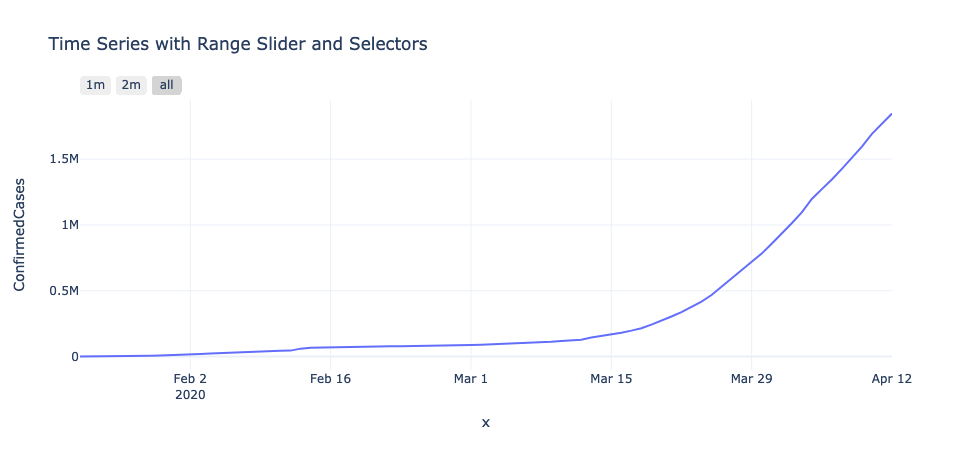

In [50]:
fig = px.line(total_k, x=total_k.index, y='ConfirmedCases', title='Time Series with Range Slider and Selectors')

fig.update_xaxes(
    rangeslider_visible=False,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=2, label="2m", step="month", stepmode="backward"),
            dict(step="all"),
            
        ])
    )
)
fig.layout.template = 'plotly_white'
fig.show()

# Parametric Modelling - Focus on Italy

In [51]:
from scipy.integrate import odeint
from scipy import optimize 
from sklearn import metrics

df = pd.read_csv(PATH + "covid_19_data.csv")
df_fit = df.loc[df['Country/Region']=='Italy']
df_fit['day_count'] = list(range(1, len(df_fit)+1)) 
t = np.array(df_fit.day_count, dtype=float) 
cases = np.array([i for i in df_fit.Confirmed], dtype=float)
recovered = df_fit.Recovered.to_numpy()
infected = np.array([x-y for x,y in zip(cases,recovered)])

## SIR Model

5.600143010469003 5.368144846232394


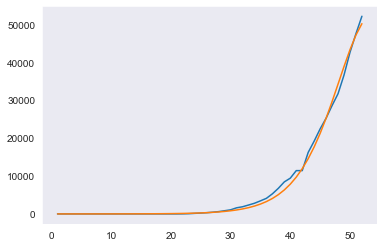

In [52]:
# Total population, N.
N = 60461826.0
# Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = 1, 0
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0
# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
beta, gamma = 0.2, 1./10 
# The SIR model differential equations.
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Initial conditions vector
y0 = S0, I0, R0
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma))
S, I, R = ret.T 

def fit_int(x, beta, gamma):
    return odeint(deriv, y0, x, args=(N, beta, gamma))[:,1] 

popt, pcov = optimize.curve_fit(fit_int, t, infected) 
fitted = fit_int(t, *popt) 
print(*popt) 
plt.plot(t, infected)
plt.plot(t, fitted) 
plt.show()  

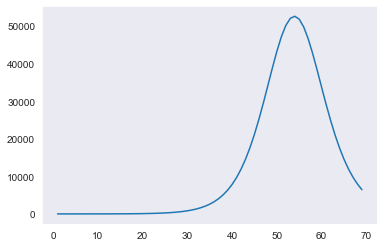

In [53]:
t_extended = np.array(list(range(1,70)), dtype=float)
fitted_new = fit_int(t_extended, *popt)
fitted_new
plt.plot(t_extended, fitted_new)
plt.show() 

## Logistic Model

### Functions

In [54]:
def growth_factor_adv(cases):
    cases_1 = cases.shift(1)
    cases_2 = cases.shift(2)
    gr_factor = (cases- cases_1)/(cases_1-cases_2)
    return gr_factor

def growth_rate(cases):
    cases_1 = cases.shift(1)
    return ((cases-cases_1)/cases_1) 

def growth_factor(cases):
    cases_1 = cases.shift(1)
    return (cases/cases_1) 

def growth_factor_test(cases):
    cases_1 = cases.shift(1)
    cases_2 = cases.shift(2) 
    return (cases_1/cases_2)

def lag_1(cases):
    return cases.shift(1) 

def lag_2(cases):
    return cases.shift(2) 

#First parametric model based on logistic function fitting 
def logistic_curve(t, p0, p1, p2):
    '''Input: parameters and variable
       Output: logistic function fitted'''
    return (p0/(1+(np.exp(-p1*(t-p2)))))

def curve_fit(): 
    '''Parameters' optimization and curve fitting'''
    popt, pcov = optimize.curve_fit(logistic_curve, t, cases) 
    print(popt)
    fitted = logistic_curve(t, *popt) 
    return fitted 

#Second model based on logistic function enriched using explanatory variables: lags and grotwh factor.

#About the growth factor we have a drawback in the prediction phase, because we cannot have it in 
#advance, therefore, it's better to use a lagged version of it. Anyway, we also tested it not lagged
#to see the results. 

def logistic_regression(p, x, lags, t):
    '''Input: parameters, explanatory variables and variable
       Output: function fitted''' 
    return ((p[0] + p[1]*x + p[2]*lags)/
            (1+(np.exp((p[3] + p[4]*x + p[5]*lags)-
                        (p[6] + p[7]*x + p[8]*lags)*t)))) 
 
#Objective function for the second model 
def objective_regr(p, x, lags, t, y):
    '''Input: parameters' vector,  explanatory variables and target variable 
       Output: objective function'''
    return logistic_regression(p, x, lags, t) - y

#Here we just use one variable, it can be lags or growth factor 
def logistic_regression1(p, x, t):
    '''Input: parameters, explanatory variables and variable
       Output: function fitted''' 
    return ((p[0] + p[1]*x)/(1+(np.exp((p[2] + p[3]*x)-(p[4] + p[5]*x)*t)))) 

def objective_regr1(p, x, t, y):
    return logistic_regression1(p, x, t) - y 
    
#Optimization and fitting 
def optimization_and_fit(p, x, lags, t, cases, test=False):
    '''Usual input for the function
       Execution: optimization and fit
       Output: fitted values'''
    if test:
        x = x_test
    res = leastsq(objective_regr, p, args=(x, lags, t, cases), maxfev=20000) 
    print(res[0]) 
    fitted = logistic_regression(res[0], x, lags, t) 
    return fitted 

#Prediction for the first model 
def curve_prediction(t_new, popt):
    t_new = np.array(list(range(1,len(t_new)+1)), dtype=float)
    fitted_new = logistic_curve(t_new, *popt)
    return fitted_new

#Prediction for the regression model based on the 2 extra variables
def regression_prediction(fitted, popt, x, lags, t, time_horizon, start=53): 
    '''Input: fitted values, parameters, variables, range of time to predict
       Output: new fitted values''' 
    for t1 in range(start, (start+time_horizon)):
        fitted = np.append(fitted, (logistic_regression(popt, x[len(x)-1], lags[len(lags)-1], t1)))
        x = np.append(x, np.log((fitted[len(fitted)-1])/(fitted[len(fitted)-2])))  
        lags = np.append(lags, np.log(fitted[len(fitted)-1])) 
    return fitted 

#Prediction with growth factor 
def regression_prediction1(fitted, popt, x, t, time_horizon, start=53): 
    for t1 in range(start, (start+time_horizon)):
        fitted = np.append(fitted, (logistic_regression1(popt, x[len(x)-1], t1)))
        x = np.append(x, np.log((fitted[len(fitted)-1])/(fitted[len(fitted)-2])))  
    return fitted 
        
#Plot of the results 
def plot(t, fitted, cases, title='Title'):
    

    second_derivative = np.gradient(np.gradient(fitted))
    print(f"MAE: {metrics.mean_absolute_error(fitted, cases)}")
    print(f"RMSE: {np.sqrt(metrics.mean_squared_error(fitted, cases))}")
    
    fig, ax = plt.subplots(figsize=(5, 3), dpi=100)
    ax.plot(t, cases, linestyle='-', marker='', label='Actual Cases')
    ax.plot(t, fitted, linestyle='-', marker='', label='Fitted Number of Cases')
    
    ax.set_xlabel("Day Count", fontweight='bold')
    ax.set_ylabel("Confirmed Cases", fontweight='bold')
    plt.title(f"{title}", fontweight='bold')
    plt.legend()
    plt.show()
    
    fig, ax = plt.subplots(figsize=(5, 3), dpi=100)
    ax.plot(t, second_derivative, linestyle='-', marker='')
    plt.title(f"Second Derivative", fontweight='bold')
    ax.set_xlabel("Day Count", fontweight='bold')
    ax.set_ylabel("", fontweight='bold')
    plt.show() 
    return  

### Preparing Inputs

In [55]:
df = pd.read_csv(PATH + "covid_19_data.csv")
df_fit = df.loc[df['Country/Region']=='Italy'] 
df_fit['day_count'] = list(range(1, len(df_fit)+1)) 
df_fit['growth_factor'] = np.log(growth_factor(df_fit['Confirmed']))
df_fit['growth_factor'].replace(np.nan, 0, inplace=True)
df_fit['gr_test'] = np.log(growth_factor_test(df_fit['Confirmed'])) 
df_fit['gr_test'].replace(np.nan, 0, inplace=True)
df_fit['lag_1'] = np.log(lag_1(df_fit['Confirmed'])) 
df_fit['lag_1'].replace(np.nan, 0, inplace=True) 
df_fit['lag_2'] = np.log(lag_2(df_fit['Confirmed'])) 
df_fit['lag_2'].replace(np.nan, 0, inplace=True) 
df_fit['second_derivative'] = np.gradient(np.gradient(df_fit['lag_1']))

#Input data taken from the fit dataframe         
lag2 = df_fit.lag_2.to_numpy()
der = df_fit.second_derivative.to_numpy()
lags = np.array([i for i in df_fit.lag_1], dtype=float) #log(lagged -1 cases) 
x = np.array([i for i in df_fit.growth_factor], dtype=float) #log(growth factor)
x_test = df_fit.gr_test.to_numpy() #log(lagged growth factor)
t = np.array(df_fit.day_count, dtype=float) #time 
cases = np.array([i for i in df_fit.Confirmed], dtype=float) #cumulative cases

[1.19874630e+05 1.95765044e-01 5.21827560e+01]
MAE: 307.1398475878933
RMSE: 467.8674826901196


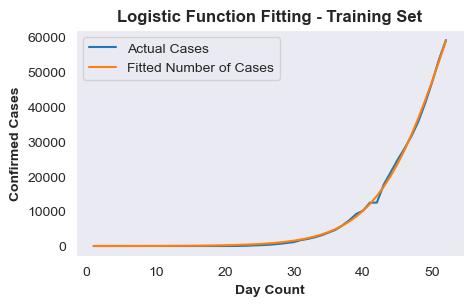

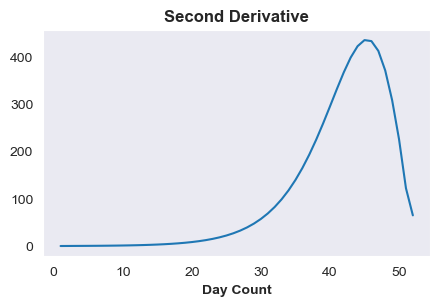

In [56]:
#Here we implement the first basic model without any other explanatory variable, each coefficient has
#its own interpretation. Here the total number of cases is estimated to be around 119000, and
#the point of trend inversion is the day number 52, so the 22th of march. 
fitted = curve_fit()
plot(t, fitted, cases, title='Logistic Function Fitting - Training Set')

[ 1.76123241e+07  7.44689357e+05  7.31728928e+05  1.66863352e+01
 -9.62979181e-01 -9.65520600e-01 -1.31364838e-03  1.77760679e-04
  1.32356154e-04]
MAE: 0.16593022775876815
RMSE: 0.24579379545754784


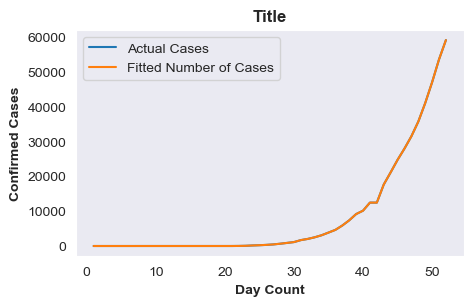

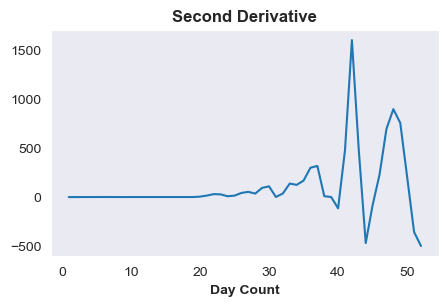

In [57]:
#Fitted values training the regression model (second model) using lags and growth factor (not lagged) 
#Very good fitting, but it is based on non-lagged growth factor, which does not make that much sense
#given that we will be forced to use the lagged one for prediction. Anyway, it seems to overfit here.

fitted = optimization_and_fit([120000,1,1,52,1,1,0.1,0.1,0.1], x, lags, t, cases)
plot(t, fitted, cases)

[-1.43302228e+04  1.85081965e+04  1.40691804e+04  7.40885670e+00
  7.89721360e+00  8.77661748e-02  1.45517773e-01  1.79354989e-01
  5.04380665e-04]
MAE: 163.11771237564406
RMSE: 368.7588220781972


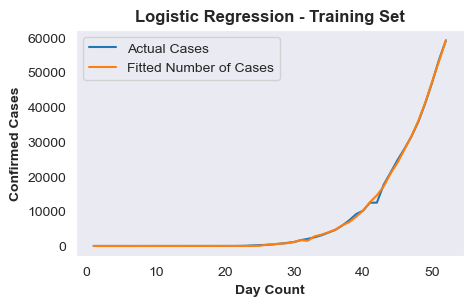

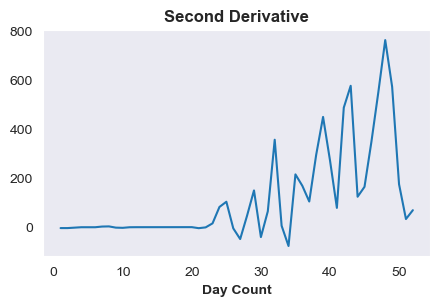

In [58]:
#Logistic regression using lagged growth factor, worse fit but overfitting risk reduced
fitted = optimization_and_fit([180000,1,1,53,1,1,0.1,0.1,0.1], x, lags, t, cases, test=True)
plot(t, fitted, cases, title='Logistic Regression - Training Set') 

[1.28831429e+05 3.43012448e+04 9.21342437e+00 5.70375358e+00
 1.70435681e-01 1.27502953e-01]
MAE: 245.15768408184596
RMSE: 402.6965776011588


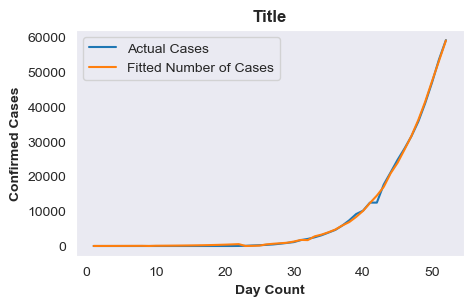

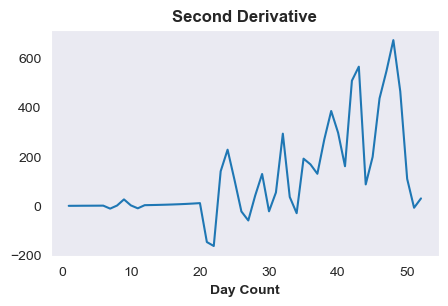

In [59]:
# Here we simplify the previous regression model using just one explanatory variable: the growth factor.
# What we gain is a little bit of interpretability of the coefficinets, this model is closer to the 
# "original" one. In exchange of this gain we loose goodness of fit, this is the trade-off between
# a parametric model and a data-centric model.
# In this case, the numerator can be still interpreted as the max number of cases, multiplying 
# the second parameter by 0, given that, in the limit case, our grotwh factor will be equal to 1.
# What we get is a more realistic estimation of that number: 128000. 
# In the original model we get  around 119000.  

# IMPORTANT: we also tested this model with the non-lagged gr. factor and the total nummber estimated
# is around 156000. This fact already here suggests how differently can be uses this model to get 
# different answers. 
# [ 1.55961900e+05, -2.00582495e+05,  9.73510488e+00,3.07246241e+00,1.74720337e-01,1.30056517e-01] 

p = [120000,1,1,1,0.1,0.1]
res = leastsq(objective_regr1, p, args=(x_test, t, cases)) 
print(res[0]) 
fitted_gr = logistic_regression1(res[0], x_test, t) 
plot(t, fitted_gr, cases) 

[-2.30638087e+03  2.03634956e+04  1.32361097e+01 -4.04087433e-01
  2.59949940e-01 -1.00199747e-02]
MAE: 172.07086175739207
RMSE: 406.2945796200593


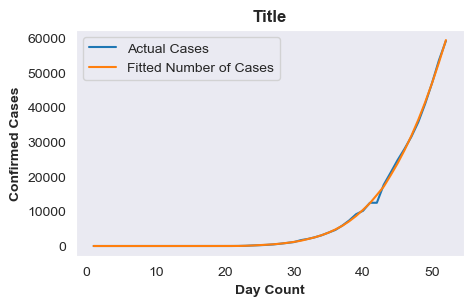

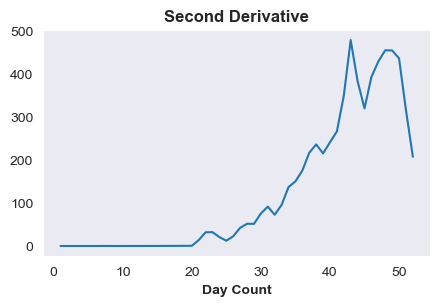

In [60]:
#Here we regress just on lags, better result but we loose interpretability of the numerator coeffcient

p = [1,1,1,1,1,1]
res = leastsq(objective_regr1, p, args=(lags, t, cases)) 
print(res[0]) 
fitted_lag = logistic_regression1(res[0], lags, t) 
plot(t, fitted_lag, cases) 

### Kaggle Week 3 Integration

In [61]:
#Here we aggregate the kaggle COVID-19 dataset for the week 3 to make test on our model 

df_kaggle = pd.read_csv(PATH + 'covid19-global-forecasting-week-3/train.csv')

df_kaggle = df_kaggle.loc[df_kaggle['Date']>='2020-03-23']
df_kaggle = df_kaggle.loc[df_kaggle['Country_Region']=='Italy']
df_kaggle = df_kaggle.drop(['Id'], axis=1)
df_kaggle = df_kaggle.rename(columns={'Date':'ObservationDate', 'Country_Region':'Country/Region',
                         'ConfirmedCases':'Confirmed', 'Fatalities':'Deaths'})
df_kaggle = df_kaggle[['ObservationDate', 'Country/Region','Confirmed', 'Deaths']]
change = {'2020-03-23': '2020/03/23', '2020-03-24':'2020/03/24', '2020-03-25':'2020/03/25',
         '2020-03-26':'2020/03/26', '2020-03-27':'2020/03/27', '2020-03-28':'2020/03/28',
         '2020-03-29':'2020/03/29', '2020-03-30':'2020/03/30', '2020-03-31':'2020/03/31'}
df_kaggle['ObservationDate'].replace(change, inplace=True) 
df_kaggle['growth_factor'] = np.log(growth_factor(df_kaggle['Confirmed']))
df_kaggle['growth_factor'].replace(np.nan, np.log(63927.0/59138.0), inplace=True)
df_kaggle['lag_1'] = np.log(lag_1(df_kaggle['Confirmed'])) 
df_kaggle['lag_1'].replace(np.nan, np.log(59138.0), inplace=True) 
df_fit1 = df_fit.drop(['Last Update', 'Recovered', 'Province/State', 'day_count'], axis=1)
pd.set_option('display.max_rows', None) 
df_fit_new = pd.concat([df_fit1, df_kaggle])
df_fit_new['day_count'] = list(range(1, len(df_fit_new)+1))
df_fit_new = df_fit_new.iloc[:61,]

MAE: 531.5023949483468
RMSE: 942.7131958082408


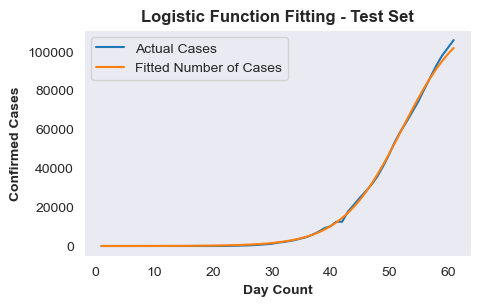

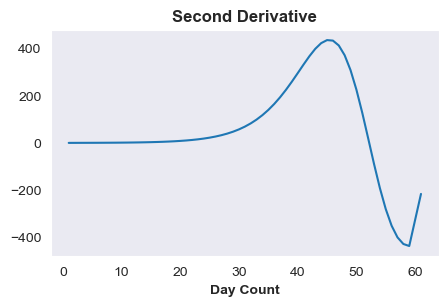

In [62]:
#Prediction error train + test, curve fitting (first model) 
t_extended = np.array([i for i in df_fit_new.day_count], dtype=float)
cases_new = np.array([i for i in df_fit_new.Confirmed], dtype=float)
popt = [1.19874628e+05, 1.95765045e-01, 5.21827559e+01]
fitted_new = curve_prediction(t_extended, popt)
plot(t_extended, fitted_new, cases_new, title='Logistic Function Fitting - Test Set') 

In [63]:
#Test prediction error 
df_fit_new['fitted'] = fitted_new
df_test = df_fit_new.loc[df_fit_new.day_count>52] 
fit_test = np.array([df_test['fitted']], dtype=float) 
cases = np.array([df_test['Confirmed']], dtype=float) 
t = np.array([df_test['day_count']], dtype=float) 
print("MAE: ", metrics.mean_absolute_error(fit_test, cases))
print("RMSE: ",np.sqrt(metrics.mean_squared_error(fit_test, cases))) 

MAE:  1827.8193074747583
RMSE:  2181.447004779465


MAE: 334.401703085223
RMSE: 715.6929429987248


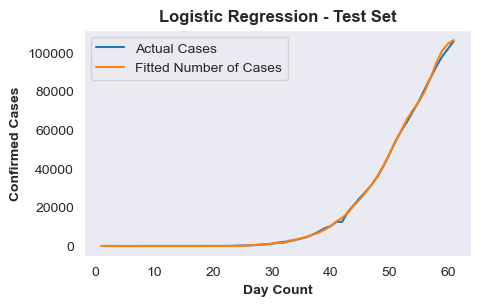

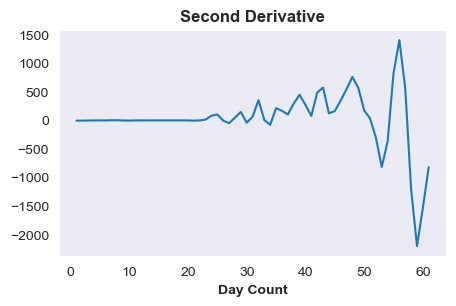

In [64]:
#Prediction using the regression model with both explanatory variables (gr. factor lagged) 
fitted_new_both = regression_prediction(fitted, [ -1.43310122e+04,  1.84950614e+04,  1.40669208e+04,
                                            7.40537657e+00, 7.89977092e+00,  8.80107420e-02,
                                            1.45419819e-01,  1.79414736e-01,5.12386818e-04], 
                                   x_test, lags, t, 9)
t_extended = np.array([i for i in df_fit_new.day_count], dtype=float)
cases_new = np.array([i for i in df_fit_new.Confirmed], dtype=float)



plot(t_extended, fitted_new_both, cases_new, title='Logistic Regression - Test Set') 

In [65]:
df_fit_new['fitted1'] = fitted_new_both
df_test = df_fit_new.loc[df_fit_new.day_count>52] 
fit_test = np.array([df_test['fitted1']], dtype=float) 
cases = np.array([df_test['Confirmed']], dtype=float) 
t = np.array([df_test['day_count']], dtype=float) 
print("MAE: ", metrics.mean_absolute_error(fit_test, cases))
print("RMSE: ",np.sqrt(metrics.mean_squared_error(fit_test, cases))) 

MAE:  1324.0425382961241
RMSE:  1638.9047876691163


MAE: 4077.1492215327085
RMSE: 11556.697060365324


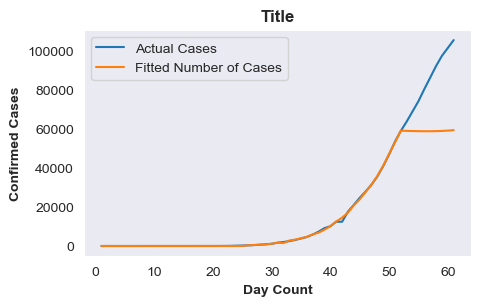

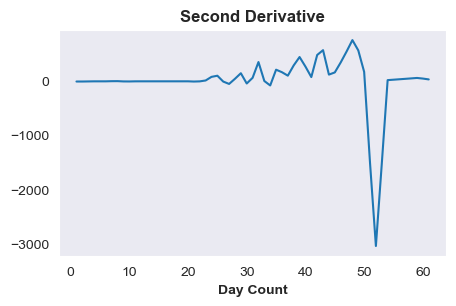

In [66]:
#Proof of probable overfitting of the model with gr. factor not lagged, it does not perform well 
fitted_new = regression_prediction(fitted, [ 1.84896470e+07,  7.64293951e+05,  7.48606938e+05,
                                            1.67346997e+01,-9.63670679e-01, -9.66244647e-01, 
                                            -1.26407692e-03,  1.71603576e-04, 
                                            1.27360369e-04], x, lags, t, 9)
t_extended = np.array([i for i in df_fit_new.day_count], dtype=float)
cases_new = np.array([i for i in df_fit_new.Confirmed], dtype=float)
plot(t_extended, fitted_new, cases_new) 

MAE: 530.7820741193611
RMSE: 1050.6933358919482


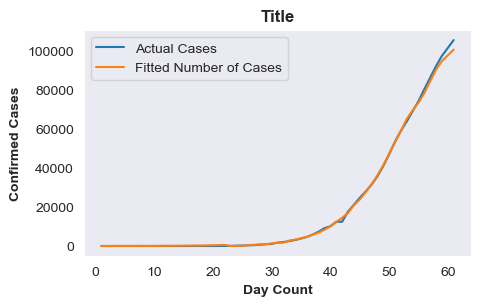

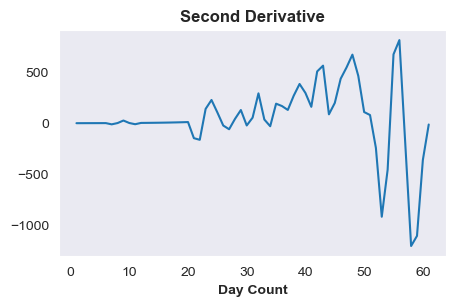

In [67]:
#Prediction based just on growth factor as exp. variable  
fitted_new = regression_prediction1(fitted_gr, [ 1.28831446e+05, 3.43009965e+04, 9.21342589e+00,
                                            5.70374450e+00,1.70435713e-01, 1.27502792e-01], x_test, 
                                   t, 9)
t_extended = np.array([i for i in df_fit_new.day_count], dtype=float)
cases_new = np.array([i for i in df_fit_new.Confirmed], dtype=float)
plot(t_extended, fitted_new, cases_new) 

In [68]:
df_fit_new['fitted'] = fitted_new
df_test = df_fit_new.loc[df_fit_new.day_count>52] 
fit_test = np.array([df_test['fitted']], dtype=float) 
cases = np.array([df_test['Confirmed']], dtype=float) 
t = np.array([df_test['day_count']], dtype=float) 
print("MAE: ", metrics.mean_absolute_error(fit_test, cases))
print("RMSE: ",np.sqrt(metrics.mean_squared_error(fit_test, cases))) 

MAE:  2181.056327669449
RMSE:  2558.402059957328


### Kaggle Week 4 Integration

In [69]:
#Aggregation of the kaggle week 4 dataset 

df_kaggle = pd.read_csv(PATH + 'covid19-global-forecasting-week-4/train.csv')
df_kaggle = df_kaggle.loc[df_kaggle['Date']>='2020-03-23'] 
df_kaggle = df_kaggle.loc[df_kaggle['Country_Region']=='Italy']
df_kaggle = df_kaggle.drop(['Id'], axis=1)
df_kaggle = df_kaggle.rename(columns={'Date':'ObservationDate', 'Country_Region':'Country/Region',
                         'ConfirmedCases':'Confirmed', 'Fatalities':'Deaths'})
df_kaggle = df_kaggle[['ObservationDate', 'Country/Region','Confirmed', 'Deaths']]
change = {'2020-03-23': '2020/03/23', '2020-03-24':'2020/03/24', '2020-03-25':'2020/03/25',
         '2020-03-26':'2020/03/26', '2020-03-27':'2020/03/27', '2020-03-28':'2020/03/28',
         '2020-03-29':'2020/03/29', '2020-03-30':'2020/03/30', '2020-03-31':'2020/03/31'}
df_kaggle['ObservationDate'].replace(change, inplace=True) 
df_kaggle['growth_factor'] = np.log(growth_factor(df_kaggle['Confirmed']))
df_kaggle['growth_factor'].replace(np.nan, np.log(63927.0/59138.0), inplace=True)
df_kaggle['lag_1'] = np.log(lag_1(df_kaggle['Confirmed'])) 
df_kaggle['lag_1'].replace(np.nan, np.log(59138.0), inplace=True) 
df_fit1 = df_fit.drop(['Last Update', 'Recovered', 'Province/State', 'day_count'], axis=1)
pd.set_option('display.max_rows', None) 
df_fit_new = pd.concat([df_fit1, df_kaggle])
df_fit_new['day_count'] = list(range(1, len(df_fit_new)+1))

MAE: 3232.219222801625
RMSE: 7758.711679036239


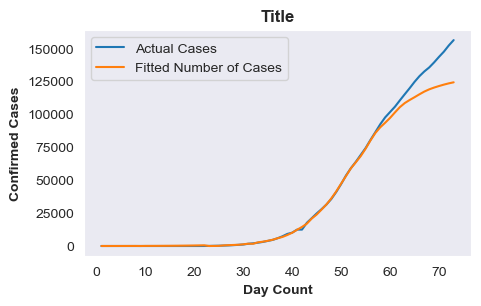

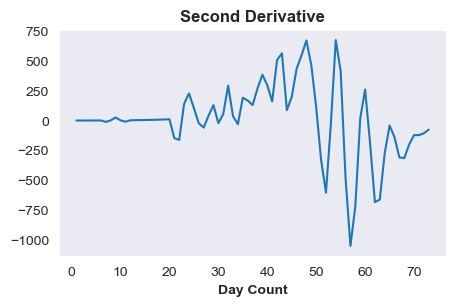

In [70]:
#Prediction of week 3 and 4 using lagged factor for training 
fitted_new = regression_prediction1(fitted_gr, [1.28831446e+05, 3.43009965e+04, 9.21342589e+00,
                                            5.70374450e+00,1.70435713e-01, 1.27502792e-01], x, t, 21)
t_extended = np.array([i for i in df_fit_new.day_count], dtype=float)
cases_new = np.array([i for i in df_fit_new.Confirmed], dtype=float)
plot(t_extended, fitted_new, cases_new) 

In [71]:
df_fit_new['fitted'] = fitted_new
df_test = df_fit_new.loc[df_fit_new.day_count>52] 
fit_test = np.array([df_test['fitted']], dtype=float) 
cases = np.array([df_test['Confirmed']], dtype=float) 
t = np.array([df_test['day_count']], dtype=float) 
print("MAE: ", metrics.mean_absolute_error(fit_test, cases))
print("RMSE: ",np.sqrt(metrics.mean_squared_error(fit_test, cases))) 

MAE:  10628.75255677441
RMSE:  14451.878687061459


MAE: 3872.469310693434
RMSE: 9421.809649113988


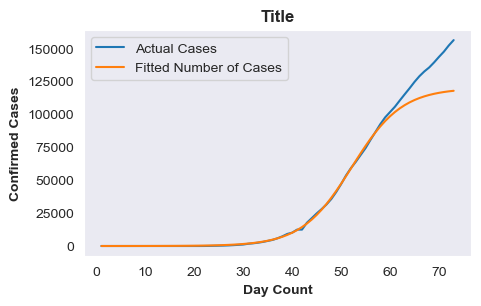

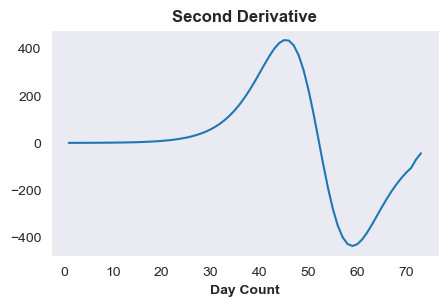

In [72]:
#Curve fitting prediction (first model) 
t_extended = np.array([i for i in df_fit_new.day_count], dtype=float)
cases_new = np.array([i for i in df_fit_new.Confirmed], dtype=float)
popt = [1.19874628e+05, 1.95765045e-01, 5.21827559e+01]
fitted_new = curve_prediction(t_extended, popt)
plot(t_extended, fitted_new, cases_new) 

In [73]:
df_fit_new['fitted'] = fitted_new
df_test = df_fit_new.loc[df_fit_new.day_count>52] 
fit_test = np.array([df_test['fitted']], dtype=float) 
cases = np.array([df_test['Confirmed']], dtype=float) 
t = np.array([df_test['day_count']], dtype=float) 
print("MAE: ", metrics.mean_absolute_error(fit_test, cases))
print("RMSE: ",np.sqrt(metrics.mean_squared_error(fit_test, cases))) 

MAE:  12700.904159811636
RMSE:  17551.10020517148


MAE: 1027.9115181769296
RMSE: 2556.215531345058


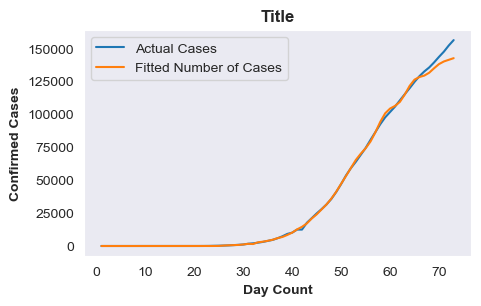

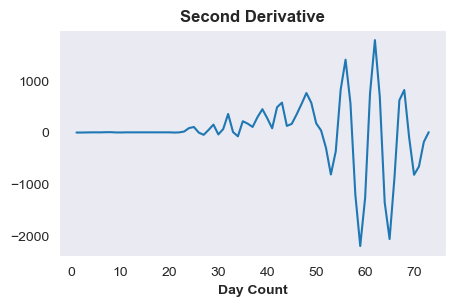

In [74]:
fitted_new = regression_prediction(fitted, [ -1.43310122e+04,  1.84950614e+04,  1.40669208e+04,
                                            7.40537657e+00,7.89977092e+00,  8.80107420e-02,  
                                            1.45419819e-01,  1.79414736e-01,5.12386818e-04], x_test,
                                   lags,t, 21)
t_extended = np.array([i for i in df_fit_new.day_count], dtype=float)
cases_new = np.array([i for i in df_fit_new.Confirmed], dtype=float)
plot(t_extended, fitted_new, cases_new) 

In [75]:
df_fit_new['fitted'] = fitted_new
df_test = df_fit_new.loc[df_fit_new.day_count>52] 
fit_test = np.array([df_test['fitted']], dtype=float) 
cases = np.array([df_test['Confirmed']], dtype=float) 
t = np.array([df_test['day_count']], dtype=float) 
print("MAE: ", metrics.mean_absolute_error(fit_test, cases))
print("RMSE: ",np.sqrt(metrics.mean_squared_error(fit_test, cases))) 

MAE:  3169.305703970589
RMSE:  4730.4899722846685


[1.61225165e+05 1.52064208e-01 5.62695192e+01]
MAE: 1457.4575551626824
RMSE: 1958.3033805769378


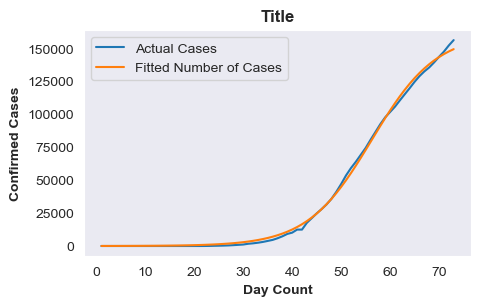

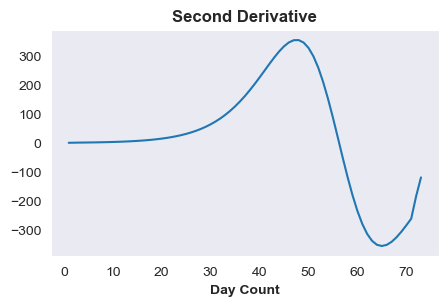

In [76]:
#Logistic fit with data up to week 4, 6th of april, to see new parameters, new guesses
#The inversion point is now 56, the total number of cases 161000
lags = np.array([i for i in df_fit_new.lag_1], dtype=float) 
x = np.array([i for i in df_fit_new.growth_factor], dtype=float) 
x_test = df_fit.gr_test.to_numpy() 
t = np.array(df_fit_new.day_count, dtype=float) 
cases = np.array([i for i in df_fit_new.Confirmed], dtype=float) 
fitted = curve_fit()
plot(t, fitted, cases) 

[ 1.76233248e+05 -2.01482891e+05  8.04161994e+00  1.38702378e+01
  1.34737137e-01  3.63822272e-01]
MAE: 729.3725757903967
RMSE: 1043.7451144147083


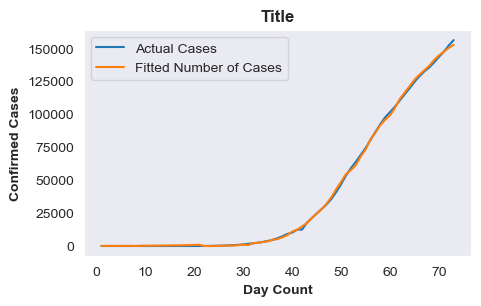

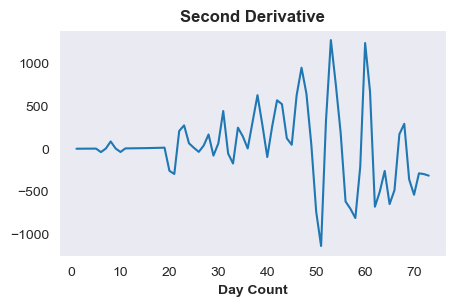

In [77]:
#Logistic regression fit with lagged growth factor, total number of cases estimated: 176000, 
#much more realistic, at this date (15/04/2020) in Italy we have around 162000, fixed end 
#of the lockdown right now: 4/05

p = [180000,1,1,1,0.1,0.1]
res = leastsq(objective_regr1, p, args=(x, t, cases)) 
print(res[0]) 
fitted = logistic_regression1(res[0], x, t) 
plot(t, fitted, cases) 

[ 2.36143233e+05  8.64884421e+04  7.96413154e+04  1.21099978e+01
 -9.91609028e-01 -8.51234350e-01 -3.44902474e-02 -7.73378239e-04
  2.93649365e-03]
MAE: 26.782820331456314
RMSE: 40.82372794488006


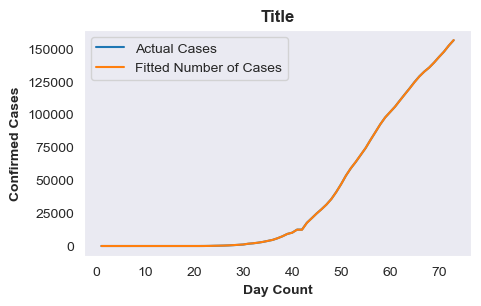

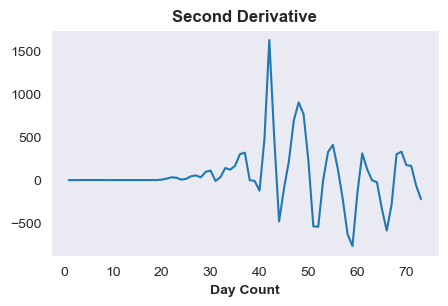

In [78]:
#non-lagged gr. factor again almost perfect fit, but no interpretability 

p = [200000,1,1,52,1,1,1,0.1,0.1]
res = leastsq(objective_regr, p, args=(x, lags, t, cases)) 
print(res[0]) 
fitted = logistic_regression(res[0], x, lags, t) 
plot(t, fitted, cases) 

# Data-centric Approach

### Preparing inputs

In [79]:
# Given dataset and Kaggle Week-3
data = pd.read_csv(PATH + "covid_19_data.csv", index_col=0)
df_kaggle = pd.read_csv(PATH + 'covid19-global-forecasting-week-3/train.csv')


data['ObsDate']=data.ObservationDate.apply(lambda x: datetime.strptime(x,'%m/%d/%Y'))
data.drop(['Last Update'],axis=1,inplace=True)
data.rename(columns={'Province/State':'Province_State','Country/Region':'Country_Region'}, inplace=True)
data.replace(to_replace='Mainland China', value='China', inplace=True)

# Consider only data after the last day of original dataset
df_kaggle = df_kaggle.loc[df_kaggle['Date']>='2020-03-23']
# Modify date format
df_kaggle['ObsDate']=df_kaggle.Date.apply(lambda x: datetime.strptime(x,'%Y-%m-%d'))
df_kaggle = df_kaggle.drop(['Id','Date'], axis=1)
df_kaggle = df_kaggle.rename(columns={'ConfirmedCases':'Confirmed', 'Fatalities':'Deaths'})
df_kaggle = df_kaggle[['ObsDate', 'Country_Region','Confirmed', 'Deaths']]
df_kaggle.head()

ObsDate Country_Region  Confirmed  Deaths
61 2020-03-23    Afghanistan       40.0     1.0
62 2020-03-24    Afghanistan       74.0     1.0
63 2020-03-25    Afghanistan       84.0     2.0
64 2020-03-26    Afghanistan       94.0     4.0
65 2020-03-27    Afghanistan      110.0     4.0

In [80]:
data = pd.concat([data[['ObsDate', 'Country_Region','Confirmed', 'Deaths']],
                  df_kaggle],axis=0).reset_index(drop=True)
print(data.shape)
data.head()

(12822, 4)


ObsDate Country_Region  Confirmed  Deaths
0 2020-01-22          China        1.0     0.0
1 2020-01-22          China       14.0     0.0
2 2020-01-22          China        6.0     0.0
3 2020-01-22          China        1.0     0.0
4 2020-01-22          China        0.0     0.0

In [81]:
granularity_filter =['Country_Region','China']

if len(granularity_filter)>0:
    # Remove only Country_Region in granularity_filter
    data = data[data.loc[:,granularity_filter[0]]!=granularity_filter[1]].reset_index(drop=True)
    
print(data.shape)
data.head()

(10405, 4)


ObsDate Country_Region  Confirmed  Deaths
0 2020-01-22      Hong Kong        0.0     0.0
1 2020-01-22          Macau        1.0     0.0
2 2020-01-22         Taiwan        1.0     0.0
3 2020-01-22             US        1.0     0.0
4 2020-01-22          Japan        2.0     0.0

### Functions

In [82]:
from sklearn.preprocessing import StandardScaler
def do_scaling(df_to_scale, feat_ls, type='standard', mm_range=(0,1)):
    ''' This function returns a scaled dataset and the used scaler. 
    
    Inputs:
    df_to_scale (object): DataFrame to be scaled
    feat_ls (list or array of str): variable which contains the names of the columns of 'df_to_scale' to be scaled
    type (str, default='standard'): type of standardizaion. If equal to 'standard', StandardScaler() is used,
                                    if equal to 'minmax', MinMaxScaler() is used.
    mm_range (tuple, default=(0,1)): represents the range of values within which the variables have to be scaled;
                                     it's used only if 'type' is equal to 'minmax'
                                     
    Outputs:
    df_scaled (obj)
    scaler (obj)
    
    '''
    
    if type=='standard':
        scaler = StandardScaler().fit(df_to_scale.loc[:,feat_ls])
        df_scaled = pd.DataFrame(scaler.transform(df_to_scale.loc[:,feat_ls])
                                 , columns=feat_ls)
        
    elif type=='minmax':
        scaler =  MinMaxScaler(feature_range=mm_range)
        df_scaled = pd.DataFrame(scaler.fit_transform(df_to_scale.loc[:,feat_ls])
                                 , columns=feat_ls)
    return df_scaled, scaler

In [83]:
def aggregate_df(data, granularity='global',
                 date_var='ObsDate',
                 columns=['Confirmed', 'Deaths','Recovered'],
                 extra_columns = [],
                 verbose=False):
    
    '''This function aggregates an input dataset according to a geographical granularity level and returns it
    together with the grouping variable.
    
    Inputs:
    data (obj): DataFrame object, representing the dataset to be aggregated
    granularity (str, default='regional'): level of geographical granularity according to which the input dataset
                                           is aggregated. Accepted values are: 'global', 'continental', 'regional',
                                           'provincial'.
    date_var (str, default='ObsDate'): name of the variable inside the dataset containing datetime values
    columns (list of str, default=['Confirmed', 'Deaths','Recovered']): names of the variables to aggregate
    extra_columns (list of str, default=[]): names of the variables within the dataset to add after the aggregation
    verbose (bool, default=False): if True, the function prints the first 30 rows of the aggregated dataset
    
    Outputs:
    group (obj)
    granularity (str)
    
    '''
    
    if granularity=='global':
        group = data.groupby(date_var, as_index=False)[columns].sum()

        granularity_var = ''
    else:
        if granularity=='continental':
            granularity_var = 'Continent'

            group = data.groupby([date_var, granularity_var], as_index=False)[columns]\
                        .sum()
            # Need to add demographic information Continent-wise #
    
        elif granularity=='regional':
            granularity_var = 'Country_Region'

            group = data.groupby([date_var, granularity_var], as_index=False)[columns]\
                        .sum()\
                        .merge(data.loc[:,[granularity_var]+extra_columns].drop_duplicates(),
                               on=granularity_var,how='left')

        elif granularity=='provincial':
            granularity_var = 'Province_State'

            group = data.groupby([date_var, granularity_var], as_index=False)[columns]\
                        .sum()\
                        .merge(data.loc[:,[granularity_var]+[x for x in extra_columns if x=='Continent']]\
                                   .drop_duplicates(),
                               on=granularity_var,how='left')
            # Need to add demographic information Province_State-wise #
        
    if verbose: print(group.iloc[:30,:])
    return group, granularity_var

Feature Engineering: Log and Inverse-Log transformations

In [84]:
def calculate_log(df_in,
                  columns=['Confirmed', 'Deaths','Recovered'],
                  verbose=False
                 ):
    '''This function returns a dataset with added log-transformed variables (log(1+X[i])).
    
    Inputs:
    df_in (obj): DataFrame object, representing the dataset to which to add the variable(s).
    columns (list of str, default=['Confirmed', 'Deaths','Recovered']): names of the variables on which the function is applied.
    verbose (bool, default=False): if True, the function prints the first 30 rows of the output dataset
    
    Outputs:
    df (obj)
    
    '''
    
    df = df_in.copy()
    if isinstance(columns, list)==False:
        columns = [columns]
        
    df[[column+"_log" for column in columns]] = df[columns].apply(lambda x: np.log1p(x))    

    # Fill inf
    df.replace([np.inf, -np.inf], 0, inplace=True)

    if verbose: print(df.iloc[:30,:])
    return df

def calculate_inverse_log(df_in, 
                          columns=['Confirmed_log', 'Deaths_log','Recovered_log'],
                          verbose=False
                         ):
    
    '''This function returns a dataset with added exp-transformed variables (exp(X[i])-1).
    
    Inputs:
    df_in (obj): DataFrame object, representing the dataset to which to add the variable(s).
    columns (list of str, default=['Confirmed_log', 'Deaths_log','Recovered_log']): names of the variables on which the 
                                                                                    function is applied.
    verbose (bool, default=False): if True, the function prints the first 30 rows of the output dataset
    
    Outputs:
    df (obj)
    
    '''
    
    df = df_in.copy()
    if isinstance(columns, list)==False:
        columns = [columns]
        
    df[[column+"_exp" for column in columns]] = df[columns].apply(lambda x: np.expm1(x))

    # Fill inf
    df.replace([np.inf, -np.inf], 0, inplace=True)

    if verbose: print(df.iloc[:30,:])
    return df

Feature Engineering: Growth Ratio, Lags and Trends

In [85]:
def calculate_growth_ratio(df_in, granularity, granularity_var,
                            columns=['Confirmed', 'Deaths','Recovered'],
                            fill_value = np.inf,
                            replace_value = True,
                            verbose=False
                           ):
    '''This function computes the Growth Ratio of one or more variables in the input dataset, grouping
    by another variable, and adds them to the dataset which is returned. 
    The Growth Ratio is computed as: X(t)/X(t-1)
    
    Inputs:
    df_in (obj): DataFrame object, representing the input dataset
    granularity (str): level of geographical granularity according to which the input dataset is aggregated.
    granularity_var (str): variable according to which groups are made. If 'granularity' is equal to 'global', no groups are made.
    columns (list of str, default=['Confirmed', 'Deaths','Recovered']): names of the variables on which the function is applied.
    fill_value (float, default=np.inf): values to fill with X(t-1) when it's at the denominator.
    replace_value (bool, default=True): if True, replace +-inf and NaN created when calculating the ratio.
    verbose (bool, default=False): if True, the function prints the first 30 rows of the output dataset
    
    Outputs:
    df (obj)

    '''        
    df = df_in.copy()
    if isinstance(columns, list)==False:
        columns = [columns]

    for column in columns:
        growth_ratio_column = column + "_gr"

        if granularity=='global':
            df[growth_ratio_column] = df.loc[:,column].shift(0, fill_value=0) / \
                                      df.loc[:,column].shift(1, fill_value=fill_value)


        else:
            df[growth_ratio_column] = df.groupby(granularity_var)[column].shift(0, fill_value=0) / \
                                      df.groupby(granularity_var)[column].shift(1, fill_value=fill_value)
    
    if replace_value:
        df.replace([np.inf, -np.inf], 0, inplace=True) # generated by n/0
        df.fillna(0, inplace=True)                     # generated by 0/0
    
    if verbose: print(df.iloc[:30,:])
    return df

def calculate_lag(df_in, granularity, granularity_var,
                  lag_list,
                  columns=['Confirmed', 'Deaths','Recovered'],
                  verbose=False
                 ):
    '''This function extracts lagged version of one or more variables in the input dataset, grouping
    by another variable, and adds them to the dataset which is returned.
    
    Inputs:
    df_in (obj): DataFrame object, representing the input dataset
    granularity (str): level of geographical granularity according to which the input dataset is aggregated.
    granularity_var (str): variable according to which groups are made. If 'granularity' is equal to 'global', no groups are made.
    lag_list (list of int, default=1): number of lags to apply to the variables of interest.
    columns (list of str, default=['Confirmed', 'Deaths','Recovered']): names of the variables on which the function is applied.
    verbose (bool, default=False): if True, the function prints the first 30 rows of the output dataset
    
    Outputs:
    df (obj)   
    '''
    
    # X_lagN(t) = X(t-N)

    df = df_in.copy()
    if isinstance(columns, list)==False:
        columns = [columns]
        
    for column in columns:
        for lag in lag_list:
            column_lag = column + "_lag" + str(lag)

            if granularity=='global':
                df[column_lag] = df.loc[:,column].shift(lag, fill_value=0)            
            else:
                df[column_lag] = df.groupby(granularity_var)[column].shift(lag, fill_value=0)
            
    if verbose: print(df.iloc[:30,:])
    return df

def calculate_trend(df_in, granularity, granularity_var,
                    lag_list,
                    columns=['Confirmed', 'Deaths','Recovered'],
                    fill_value = np.inf,
                    replace_value = True,
                    verbose=False
                   ):
    
    '''This function computes the Trend of one or more variables in the input dataset, grouping
    by another variable, and adds them to the dataset which is returned. 
    The Trend is computed as: 100 * (X(t)-X(t-n))/X(t-n), with n=1,...,N
    
    Inputs:
    df_in (obj): DataFrame object, representing the input dataset
    granularity (str): level of geographical granularity according to which the input dataset is aggregated.
    granularity_var (str): variable according to which groups are made. If 'granularity' is equal to 'global', no groups are made.
    lag_list (list of int, default=1): number of lags to apply to the variables of interest.
    columns (list of str, default=['Confirmed', 'Deaths','Recovered']): names of the variables on which the function is applied.
    fill_value (float, default=np.inf): values to fill with X(t-1) when it's at the denominator.
    replace_value (bool, default=True): if True, replace +-inf and NaN created when calculating the ratio.
    verbose (bool, default=False): if True, the function prints the first 30 rows of the output dataset
    
    Outputs:
    df (obj)

    '''        
    # X_trendN = 100 * [X(t)-X(t-N)]/X(t-N)
    
    df = df_in.copy()
    if isinstance(columns, list)==False:
        columns = [columns]

    for column in columns:
        for lag in lag_list:
            trend_column_lag = column + "_trend" + str(lag)
            
            if granularity=='global':
                df[trend_column_lag] = 100 * (df.loc[:,column].shift(0, fill_value=0) - 
                                              df.loc[:,column].shift(lag, fill_value=0)) / \
                                              df.loc[:,column].shift(lag, fill_value=fill_value)
            else:
                df[trend_column_lag] = 100 * (df.groupby(granularity_var)[column].shift(0, fill_value=0) - 
                                              df.groupby(granularity_var)[column].shift(lag, fill_value=0)) / \
                                              df.groupby(granularity_var)[column].shift(lag, fill_value=fill_value)
    
    if replace_value:
        df.replace([np.inf, -np.inf], 0, inplace=True) # generated by n/0
        df.fillna(0, inplace=True)                     # generated by 0/0
    
    if verbose: print(df.iloc[:30,:])
    return df

Splitting function

In [86]:
def split(df_in, prop=0.75, date_var='ObsDate', day='', columns='', outputs=['Confirmed','Deaths','Recovered']):
    '''This function splits an input dataset into two portions either based on data proportion or according to
    the values taken by a datetime variable. It also may divide into X and y variables.
    
    Inputs:
    df_in (obj): DataFrame object, representing the input dataset.
    prop (float, default=0.75): proportion size according to which the split is performed
    date_var (str, default='ObsDate'): name of the variable inside the dataset containing datetime values
    day (datetime, default=''): if not '', the split is performed according to the variable 'day', otherwise 
                                according to data proportions.
    columns (list of str, default=''): variables to be put in an X DataFrame.
    outputs (list of str, default=['Confirmed','Deaths','Recovered']): variables to be put in a y DataFrame.
    
    Outputs:
    (1) (df_train (obj), df_test (obj))
    (2) (X_train (obj), y_train (obj), X_test (obj), y_test (obj))
    '''
    if day=='':
        size = int(df_in.shape[0] * prop)
        df_train= df_in.iloc[:size,:]
        df_test = df_in.iloc[size:,:]
        
    else:
        df_train= df_in[df_in.loc[:,date_var] <= day]
        df_test= df_in[df_in.loc[:,date_var] > day]
    
    if date_var in [*df_in.columns]:
        last_date_train = df_train.loc[:,date_var][-1:].values
        if any(last_date_train == df_test.loc[:,date_var].values):
            df_train = pd.concat([df_train,
                                 df_test[last_date_train == df_test.loc[:,date_var].values]], axis=0)
            df_test = df_test[last_date_train != df_test.loc[:,date_var].values]

    if columns == '': return df_train , df_test
    else:
        X_train = df_train.loc[:,columns]
        y_train = df_train.loc[:,outputs]
        X_test = df_test.loc[:,columns]
        y_test = df_test.loc[:,outputs]        
        
        return X_train, y_train, X_test, y_test

def split_date(df_in, prop=0.75, date_var='ObsDate', day='', columns='', outputs=['Confirmed','Deaths','Recovered']):
    '''This function splits an input dataset into two portions either based on dates proportion or according to
    the values taken by a datetime variable. It also may divide into X and y variables. Dates proportion are evaluated
    on the unique values taken by the variable with datetime values.
    
    Inputs:
    df_in (obj): DataFrame object, representing the input dataset.
    prop (float, default=0.75): proportion size according to which the split is performed
    date_var (str, default='ObsDate'): name of the variable inside the dataset containing datetime values
    day (datetime, default=''): if not '', the split is performed according to the variable 'day', otherwise 
                                according to dates proportions.
    columns (list of str, default=''): variables to be put in an X DataFrame.
    outputs (list of str, default=['Confirmed','Deaths','Recovered']): variables to be put in a y DataFrame.
    
    Outputs:
    (1) (df_train (obj), df_test (obj))
    (2) (X_train (obj), y_train (obj), X_test (obj), y_test (obj))
    '''

    if day=='':
        date_list = df_in.loc[:,date_var].unique()
        size = int(len(date_list) * prop)

        date_th = date_list[:size][-1]

    else:
        date_th = day

    date_cond = df_in.loc[:,date_var].values <= date_th

    df_train= df_in.iloc[date_cond,:]
    df_test = df_in.iloc[~date_cond,:]
    
    
    if columns == '': return df_train , df_test
    else:
        X_train = df_train.loc[:,columns]
        y_train = df_train.loc[:,outputs[:3]]
        X_test = df_test.loc[:,columns]
        y_test = df_test.loc[:,outputs[:3]]        
        
        return X_train, y_train, X_test, y_test



Functions for Grid-Search

In [87]:
import itertools as it
def get_params_comb(parameters, technique):
    '''This function finds all the possible combinations of parameters, starting from a grid of parameters. It also
    does not consider all the parameters not related to the technique (method) of interest.
    
    Inputs:
    parameters (dict): variable containing the grid of parameters. The structure is like: {'parameter_n': [value_0,...,value_N]}
    technique (str): technique (method) of interest.
    
    Outputs:
    combinations (list of tuples): each tuple represents one combination of parameters.
    allNames (list of str): names of parameters for the technique (method) of interest.
    
    '''
    
    my_dict=parameters.copy()
    
    if technique == 'RF': 
        del(my_dict['eta'])
        del(my_dict['reg_lambda'])
        del(my_dict['alpha'])
        del(my_dict['C'])
        del(my_dict['kernel'])
        del(my_dict['epsilon'])

    elif technique == 'XGB':
        del(my_dict['ccp_alpha'])
        del(my_dict['alpha'])
        del(my_dict['C'])
        del(my_dict['kernel'])
        del(my_dict['epsilon'])

    elif technique == 'Ridge':
        del(my_dict['n_estimators'])
        del(my_dict['ccp_alpha'])
        del(my_dict['eta'])
        del(my_dict['reg_lambda'])
        del(my_dict['reg_alpha'])
        del(my_dict['C'])
        del(my_dict['kernel'])
        del(my_dict['epsilon'])

    elif technique == 'SVR':
        del(my_dict['n_estimators'])
        del(my_dict['ccp_alpha'])
        del(my_dict['eta'])
        del(my_dict['reg_lambda'])
        del(my_dict['reg_alpha'])
        del(my_dict['alpha'])
        
    allNames = sorted(my_dict)
    combinations = list(it.product(*(my_dict[Name] for Name in allNames)))
    
    return combinations, allNames

def get_params(parameters, i, technique):
    '''This function returns the i^th combination of parameters, starting from a grid of parameters
    
    Inputs:
    parameters (dict): variable containing the grid of parameters. The structure is like: {'parameter_n': [value_0,...,value_N]}
    i (int): index used for extracting a particular combination of parameters.
    technique (str): technique (method) of interest.
    
    Outputs:
    params (dict)
    '''
    parameters_combinations, parameters_names = get_params_comb(parameters, technique)
    
    params = {}
    # Cycle all the parameters
    for n in range(len(parameters_names)):
        params[parameters_names[n]] = parameters_combinations[i][n]
        
    return params

ML function

In [88]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.model_selection import TimeSeriesSplit

from sklearn import metrics

import statsmodels.api as sm

def get_fitted_model(X, y,
                     parameters, technique='XGB'):
    
    '''This function returns a fitted model
    
    Inputs:
    X (obj/array): model input
    y (obj/array): model ouput
    parameters (dict): parameters with which to fit the model
    technique (str,default='XGB'): type of model to be used
    
    Outputs:
    model (obj)
    
    '''
    
    if technique=='XGB':
        model = XGBRegressor(n_estimators=parameters['n_estimators'],
                             reg_lambda=parameters['reg_lambda'],
                             reg_alpha=parameters['reg_alpha'],
                             eta=parameters['eta']                        
                                )
    elif technique == 'RF':
        
        model = RandomForestRegressor(n_estimators=parameters['n_estimators'],
                                      ccp_alpha=parameters['ccp_alpha'])  

    elif technique == 'Ridge':
        
        model = Ridge(alpha=parameters['alpha'])  

    elif technique == 'SVR':
        
        model = SVR(kernel = parameters['kernel'],
                    C = parameters['C'],
                    epsilon = parameters['epsilon']
                   )  
        
    model.fit(X,y)
    
    return model

Performance Evaluation functions

In [89]:
def get_diag_df(y_test, y_pred_test, y_train=[], y_pred_train=[], spl=np.nan):
    ''' This function returns a DataFrame object containing performance measures (MAE, MSE, RMSE, R2).
    
    Inputs:
    y_test (array of float): ground truth for the test set
    y_pred_test (array of float): predictions for the test set
    y_train (array of float, default=[]): ground truth for the training set
    y_pred_train (array of float, default=[]): predicitons for the training set
    spl (float, default=np.nan): number of split. Useful when performing any kind of Cross-Validation, in order to store
                                 store performance for each single split.
    
    Outputs:
    diag_df (obj)
    
    '''
    mae_test   = metrics.mean_absolute_error(y_test, y_pred_test)
    mse_test   = metrics.mean_squared_error(y_test, y_pred_test)
    rmse_test  = np.sqrt(metrics.mean_squared_error(y_test, y_pred_test))
    r2_test    = metrics.r2_score(y_test, y_pred_test)

    
    if (len(y_train)>0) & (len(y_pred_train)>0):
        mae_train  = metrics.mean_absolute_error(y_train, y_pred_train)
        mse_train  = metrics.mean_squared_error(y_train, y_pred_train)
        rmse_train = np.sqrt(metrics.mean_squared_error(y_train, y_pred_train))
        r2_train   = metrics.r2_score(y_train, y_pred_train)
        
        diag_df = pd.DataFrame(data = np.array([[0,spl,mae_train, mse_train, rmse_train, r2_train],
                                                [1,spl,mae_test, mse_test, rmse_test, r2_test]]),
                               columns = ['DF','SPLIT','MAE','MSE','RMSE','R2'])
        
    else:     
        diag_df = pd.DataFrame(data = np.array([[1, spl, mae_test, mse_test, rmse_test, r2_test]]),
                               columns = ['DF','SPLIT','MAE','MSE','RMSE','R2'])
        
    if np.isnan(spl): diag_df.drop(['SPLIT'], inplace=True)

    return diag_df

In [90]:
def plot_residuals(y_pred_train, error_train
                  , y_pred_test, error_test):
    '''This function plots Predicted Values VS Residuals
    
    Inputs:
    y_pred_train (array of float): predicted values on the training set
    error_train (array of float): prediction error on the training set
    y_pred_test (array of float): predicted values on the test set
    error_test (array of float): prediction error on the test set
    
    Outpus:
    ---
    
    '''
    plt.scatter(y_pred_train,error_train, c="b", label="training data")
    plt.scatter(y_pred_test,error_test, c="g", label="test data")
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.legend(loc="upper left")
    plt.hlines(y=0, xmin=-10, xmax=50, color="r")
    plt.xlim([-10,50])
    plt.show()
    
def eval_distr(var, dist_name):
    ''' This function tests the distribution of the input variable, displays a QQ-plot and prints the statistics and 
    p-value of a Kolmogorov-Smirnov test.
    
    Inputs:
    var (array of float): variable to assess
    dist_name (str): name of the distribution to test. Accepted values: 'beta', 'expon', 'gamma', 'norm', 'uniform'.
    
    Outputs:
    ---
    
    '''    
    from scipy import stats
    # We test a distribution
    dist = getattr(scipy.stats, dist_name)
    param = dist.fit(var)

    # We generate a sample of size  len(x) of data distributed according to distribution dist
    # The function rvs generates a sample with distribution dist with mean loc and std scale
    test_dist = dist.rvs(*param[0:-2],loc=param[-2]
                         , scale=param[-1],size = len(var))
    test_dist.sort()

    # We create the percentiles for both distributions
    percs = np.linspace(0,100,21)
    q_a = np.percentile(var, percs)
    q_b = np.percentile(test_dist, percs)

    # and generate the QQ-plot 
    plt.plot(q_a,q_b, ls="", marker="o")
    plt.title("QQ plot: fitting a "+dist_name+" distribution")
    x = np.linspace(np.min((q_a.min(),q_b.min())), np.max((q_a.max(),q_b.max())))
    plt.plot(x,x, color="k", ls="--")
    plt.show()

    plt.hist(var,alpha=.3, density=True)
    plt.hist(test_dist,alpha=.3, density=True)
    plt.show()
    
    # Under the null hypothesis the two distributions are identical
    # if p-value<.05 -> reject H0
    
    try:
        D, p_value = stats.kstest(x, dist_name)
        print("KS test statistic: ", D)
        print("p.value: ", p_value)
    except ErrorName:
        print("Not enough inputs to test",dist_name,"distribution!!!")
        print(ErrorName)

Walk-Forward Cross-Validation

In [91]:
def WF_CV(df_train, columns, outputs_selected, 
          parameters_grid, technique,
          n_splits=5, 
          refit=True, score_to_opt = 'MAE',
          out=0, verbose=False
         ):
    
    '''This function performs a Walk-Forward Cross-Validation.
    
    Inputs:
    df_train (obj): DataFrame object on which to perform the CV.
    columns (list of str): variables used as features for the prediction task.
    outputs_selected (list of str): variables to predict.
    parameters_gird (dict): variable containing the grid of parameters.
                            The structure is like: {'parameter_n': [value_0,...,value_N]}
    technique (str): technique (method) of interest.
    n_splits (int, default=5): number of splits to perform for the CV.
    refit (bool, default=True): if True, the outputs contain also the model with best parameters combination fitted
                                on the entire dataset.
    score_to_opt (str, default='R2'): name of the score to optimize in order to choose the best parameters combination.
    out (list or array of int, default=0): index related to 'outputs_selected' in order to easily predict only one variable.
    verbose (bool, default=False): if True, the function prints the progress of each split and parameters combination.

    Outputs:
    best_score (float)
    best_diag_df (obj)
    best_params (dict)
    best_model (obj, optional)
    
    '''
    
    iterations_number = len(get_params_comb(parameters_grid,technique)[0])
    if verbose:
        print( "\n-----------------------------------------------------------------------------------------------------------\n"
              , "\nRegression technique: ", technique
              , "\nNumber of possible combinations: ",iterations_number,"\n")

    # Loop: evaluate all the possible combinations
    for i in range(iterations_number):
        print("Iteration number:",i,"(",np.round(i/iterations_number*100,0),"%)")
        
        # Get i^th parameters combination
        parameters = get_params(parameters_grid, i, technique)
        
        # Initialize variables for iteration i
        diag_df     = [pd.DataFrame(columns = ['DF','SPLIT','MAE','MSE','RMSE','R2']) for _ in range(len(outputs_selected))]
        feat_imp_df = [pd.DataFrame(columns = columns)                                for _ in range(len(outputs_selected))]
        spl = 0
        
        tscv = TimeSeriesSplit()
        for train_index, test_index in tscv.split(df_train):
            spl += 1

            df_train2 = df_train.copy()

            # Split 'df_train2'
            df_train_tr = df_train2.loc[train_index,:]
            df_train_te = df_train2.loc[test_index,:]
            if verbose:
                print("Split",spl,"\n",
                      "- Train len:",len(train_index),
                      "--- LAST train date:",pd.to_datetime(df_train_tr.loc[:,date_var].values[-1]).strftime("%d-%m-%Y"),"\n",
                      "- Test len:",len(test_index),
                      " --- FIRST test date:",pd.to_datetime(df_train_te.loc[:,date_var].values[0]).strftime("%d-%m-%Y"),"\n",
                      "\n"
                     )

            
            # TRAINING         #################################################################################################
            
            # Initialize
            y_pred_train = pd.DataFrame(columns=outputs_selected)
            # Model(s) fitting
            model_0 = get_fitted_model(df_train_tr.loc[:,columns],
                                       df_train_tr.loc[:,outputs_selected[0]],
                                       parameters, technique
                                      )
            # Store feature importance for predicting the o_th output for the day 'd'
            try:
                feat_imp_df[0] = pd.concat([feat_imp_df[0],
                                            pd.DataFrame(data=np.array(model_0.feature_importances_).reshape(1,-1),
                                                         columns=columns, index=['Split'+str(spl)]
                                                        )], axis=0)
            except:
                pass
            
            # Make predictions on the training set
            y_pred_train[outputs_selected[0]] = model_0.predict(df_train_tr.loc[:,columns])
            
            ####################################################################################################################

            # Update for computing training errors
            df_train2.loc[train_index, outputs_selected] = y_pred_train.values

            
            # TESTING         ##################################################################################################
            
            # Loop for test predictions
            dates_array = df_train_te.loc[:,date_var].unique()   
            for d in dates_array:
                row_idx = df_train_te.loc[:,date_var].values == d

                # Initialize
                y_pred_test = pd.DataFrame(columns=outputs_selected)
                # Predict the first output for the day 'd'
                y_pred_test[outputs_selected[0]] = model_0.predict(df_train_te.loc[:,columns][row_idx])
                # Update 'df_train2'
                df_train2.loc[test_index[row_idx], outputs_selected[0]] = y_pred_test.loc[:,outputs_selected[0]].values
                df_train2 = calculate_lag(df_train2, granularity, granularity_var,
                                          lag_list = [1],
                                          columns=outputs_selected, 
                                          verbose=False)
                df_train2 = calculate_trend(df_train2, granularity, granularity_var,
                                            lag_list = [7,14],
                                            columns=[o+'_lag1' for o in outputs_selected], 
                                            verbose=False)
                df_train2 = calculate_growth_ratio(df_train2, granularity, granularity_var,
                                                   columns=[o+'_lag1' for o in outputs_selected],
                                                   verbose=False)
                # Split 'df_train2'
                df_train_tr = df_train2.loc[train_index,:]
                df_train_te = df_train2.loc[test_index,:]
            
            ####################################################################################################################

            
            # At this point, in the column(s) 'outputs_selected', I only have the predicted values,
            # both for train and test. Need to transform the predictions back to linear scale
            # in order to compare them with the ground truth and compute performance measures.

            
            # PERFORMANCE EVALUTATION       ####################################################################################
            
            for o in range(len(outputs_selected)): 
                if outputs_selected[o].endswith('_log'):
                    # e.g. 'Confirmed_log'
                    # In order to assess, transform back to original scale
                    df_train2 = calculate_inverse_log(df_train2, 
                                                      columns=outputs_selected[o],
                                                      verbose=False
                                                     )
                    extra_str = '_exp'
                else:
                    extra_str = ''

                y_test       = df_train.loc[ test_index, outputs_selected[o]+extra_str]
                y_pred_test  = df_train2.loc[test_index, outputs_selected[o]+extra_str]

                # Diagnostics DataFrame
                diag_df[o] = pd.concat([diag_df[o],
                                        get_diag_df(y_test, y_pred_test, spl=spl)], axis=0)
            
            ####################################################################################################################
            
        # END OF ITERATION i
        # Compare performance of the i^th parameters combination with the previous ones
        if i==0: 
            best_score = diag_df[out].groupby('DF')[score_to_opt].mean()[1]
            best_diag_df = diag_df[out]
            best_params = parameters
            
        else:
            if ((score_to_opt=='R2')&(best_score < diag_df[out].groupby('DF')[score_to_opt].mean()[1])) | \
               ((score_to_opt!='R2')&(best_score > diag_df[out].groupby('DF')[score_to_opt].mean()[1])):
                best_score = diag_df[out].groupby('DF')[score_to_opt].mean()[1]
                best_diag_df = diag_df[out]
                best_params = parameters
        
    # ASSESSED ALL PARAMETERS COMBINATIONS
    if refit:
        best_model = get_fitted_model(df_train.loc[:,columns],
                                      df_train.loc[:,outputs_selected[out]],
                                      best_params, technique
                                     )
        return best_score, best_params, best_model
    
    else:
        
        return best_score, best_params     

## Predicting Global Confirmed Cases

In [92]:
granularity = 'global' # 'global', 'continental', 'regional', 'provincial'
date_var = 'ObsDate' # 'ObservationDate', 'ObsDate'

outputs = [
            # Outputs (1)
            'Confirmed','Deaths','Recovered',
            # Outputs (2)
            'Confirmed_log_exp', 'Deaths_log_exp', 'Recovered_log_exp',
            # Outputs (3)
            'Confirmed_log', 'Deaths_log', 'Recovered_log'    
            ]

outputs_selected = outputs[-3]

if isinstance(outputs_selected, list)==False:
    outputs_selected = [outputs_selected]

In [93]:
outputs_selected

['Confirmed_log']

In [94]:
group, granularity_var = aggregate_df(data, granularity,
                                     date_var,
                                     columns=['Confirmed', 'Deaths'],
                                     verbose=False)

group = calculate_log(group, 
                      columns=['Confirmed', 'Deaths'],
                      verbose=False)

for o in range(len(outputs_selected)):
    if outputs_selected[o].endswith('_log'):
        # e.g. 'Confirmed_log'
        # In order to assess, transform back to original scale
        group  = calculate_inverse_log(group, 
                                       columns=outputs_selected[o],
                                       verbose=False
                                      )

################################################################################################################################

group = calculate_lag(group, granularity, granularity_var,
                      lag_list = [1],
                      columns=outputs_selected, 
                      verbose=False)


group = calculate_trend(group, granularity, granularity_var,
                        lag_list = [7,14],
                        columns=[o+'_lag1' for o in outputs_selected], 
                        verbose=False)

group = calculate_growth_ratio(group, granularity, granularity_var,
                               columns=[o+'_lag1' for o in outputs_selected],
                               verbose=False)

exp_df = group.copy()

print(group.shape)
print([*group.columns])
group.head()

(77, 10)
['ObsDate', 'Confirmed', 'Deaths', 'Confirmed_log', 'Deaths_log', 'Confirmed_log_exp', 'Confirmed_log_lag1', 'Confirmed_log_lag1_trend7', 'Confirmed_log_lag1_trend14', 'Confirmed_log_lag1_gr']


ObsDate  Confirmed  Deaths  Confirmed_log  Deaths_log  Confirmed_log_exp  \
0 2020-01-22        8.0     0.0       2.197225         0.0                8.0   
1 2020-01-23       14.0     0.0       2.708050         0.0               14.0   
2 2020-01-24       25.0     0.0       3.258097         0.0               25.0   
3 2020-01-25       39.0     0.0       3.688879         0.0               39.0   
4 2020-01-26       56.0     0.0       4.043051         0.0               56.0   

   Confirmed_log_lag1  Confirmed_log_lag1_trend7  Confirmed_log_lag1_trend14  \
0            0.000000                        0.0                         0.0   
1            2.197225                        0.0                         0.0   
2            2.708050                        0.0                         0.0   
3            3.258097                        0.0                         0.0   
4            3.688879                        0.0                         0.0   

   Confirmed_log_lag1_gr  
0               0.000000  
1               0.000000  
2               1.232487  
3               1.203115  
4               1.132219

In [95]:
columns = [*exp_df.columns]

if granularity=='global': [columns.remove(c) for c in ['Province_State','Country_Region','Continent'] if c in columns]
elif granularity=='continental': [columns.remove(c) for c in ['Province_State','Country_Region'] if c in columns]
elif granularity=='regional': [columns.remove(c) for c in ['Province_State'] if c in columns]

[columns.remove(c) for c in [   # Geography
                                'Province_State',
                                'Country_Region',
                            ] + outputs
                    if c in columns]

columns

['ObsDate',
 'Confirmed_log_lag1',
 'Confirmed_log_lag1_trend7',
 'Confirmed_log_lag1_trend14',
 'Confirmed_log_lag1_gr']

In [96]:
# SETTINGS

technique = 'SVR' # RandomForestRegressor, XGBRegressor, Ridge, SVR
parameters_grid = {'n_estimators': [500, 1000, 2000],
#                  # Random Forest
                   'ccp_alpha': [0.01, 0.005, 0.001],
#                  # XGBoost  
                   'reg_lambda': [0.13, 0.35, 0.65, 0.8],
                   'reg_alpha': [0.13, 0.35, 0.65, 0.8],
                   'eta': [0.3,0.2,0.1],
#                  # Ridge Regression  
                   'alpha': [0.1, 1, 10],
#                  # SVR
                   'kernel': ['linear'],
                   'C': [0.0035, 0.007, 0.015, 0.018, 0.019],
                   'epsilon': [0.003, 0.005, 0.006]
                  }

n_splits = 5
split_mode = 'data' # 'date', 'data'
prop_data, prop_date = 0.8, 0.8
split_day = group.ObsDate[60] # last day of original dataset

### Walk-Forward CV

In [97]:
# Initialize
exp2_df = exp_df.copy()

if split_mode=='data':
    # Split according to DATA proportions
    df_train, df_test = split(exp2_df, prop=prop_data, day=split_day, outputs=outputs_selected)
elif split_mode=='date':
    # Split according to DATE proportions
    df_train, df_test = split_date(exp2_df, prop=prop_data, day=split_day, outputs=outputs_selected)
    
initial_split = [df_train.shape[0], df_test.shape[0]]
d = df_test.loc[:,date_var].unique()[0] # first validation day
l = df_test.loc[:,date_var].unique()[-1] # last validation day
print("Train-Validation Split:",df_train.shape, df_test.shape)
print("First validation Date:", pd.to_datetime(d).strftime("%d-%m-%Y"))
print("Last  validation Date:", pd.to_datetime(l).strftime("%d-%m-%Y"))

Train-Validation Split: (61, 10) (16, 10)
First validation Date: 23-03-2020
Last  validation Date: 07-04-2020


In [98]:
outputs_selected

['Confirmed_log']

In [99]:
best_score, best_params, best_model = WF_CV(df_train, columns[1:], outputs_selected,
                                            parameters_grid, technique,
                                            n_splits=5, out=0,
                                            score_to_opt='MAE',
                                            verbose=False)

Iteration number: 0 ( 0.0 %)
Iteration number: 1 ( 7.0 %)
Iteration number: 2 ( 13.0 %)
Iteration number: 3 ( 20.0 %)
Iteration number: 4 ( 27.0 %)
Iteration number: 5 ( 33.0 %)
Iteration number: 6 ( 40.0 %)
Iteration number: 7 ( 47.0 %)
Iteration number: 8 ( 53.0 %)
Iteration number: 9 ( 60.0 %)
Iteration number: 10 ( 67.0 %)
Iteration number: 11 ( 73.0 %)
Iteration number: 12 ( 80.0 %)
Iteration number: 13 ( 87.0 %)
Iteration number: 14 ( 93.0 %)


In [100]:
print(technique,":","\n",
      "> Best MAE:",best_score,"\n",
      "> Best parameters:",best_params,"\n")

SVR : 
 > Best MAE: 25096.033711448144 
 > Best parameters: {'C': 0.019, 'epsilon': 0.006, 'kernel': 'linear'} 



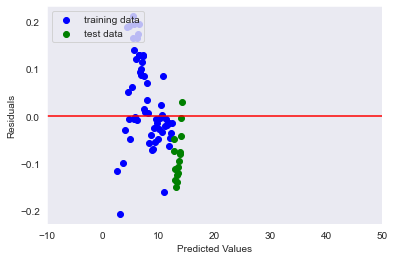

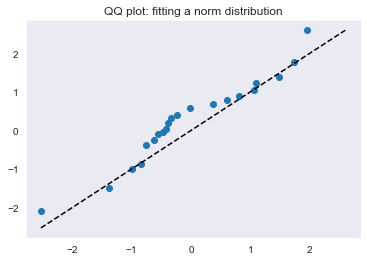

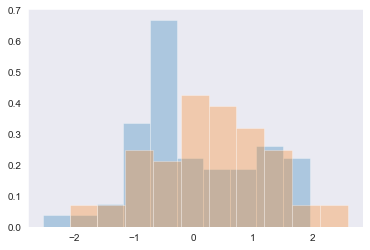

KS test statistic:  0.17193797619550033
p.value:  0.09209614269874293


In [101]:
# Initialize
df_train2 = df_train.copy()
df_test2 = df_test.copy()

# Make predictions on the training set
y_pred_train = best_model.predict(df_train2.loc[:,columns[1:]])
# Update for computing training errors
df_train2.loc[:, outputs_selected] = y_pred_train

# TESTING         ##################################################################################################

# Loop for test predictions
dates_array = df_test2.loc[:,date_var].unique()   
for d in dates_array:
    row_idx = df_test2.loc[:,date_var].values == d    

    # Predict the first output for the day 'd'
    y_pred_test = best_model.predict(df_test2.loc[:,columns[1:]][row_idx])
    # Update 'df_test2'
    df_test2.loc[row_idx, outputs_selected[0]] = y_pred_test
    # Update on the entire dataset
    exp2_df = pd.concat([df_train2,df_test2], axis=0)
    exp2_df = calculate_lag(exp2_df, granularity, granularity_var,
                            lag_list = [1],
                            columns=outputs_selected, 
                            verbose=False)
    exp2_df = calculate_trend(exp2_df, granularity, granularity_var,
                              lag_list = [7,14],
                              columns=[o+'_lag1' for o in outputs_selected], 
                              verbose=False)
    exp2_df = calculate_growth_ratio(exp2_df, granularity, granularity_var,
                                     columns=[o+'_lag1' for o in outputs_selected],
                                     verbose=False)
    # Split 'exp2_df'
    df_train2 = exp2_df.iloc[:initial_split[0],:]
    df_test2 = exp2_df.iloc[initial_split[0]:,:]

####################################################################################################################

exp2_df = pd.concat([df_train2,df_test2], axis=0)

# At this point, in the column(s) 'outputs_selected', I only have the predicted values,
# both for train and test. Need to transform the predictions back to linear scale
# in order to compare them with the ground truth and compute performance measures.

# PERFORMANCE EVALUTATION       ####################################################################################

for o in range(len(outputs_selected)): 
    if outputs_selected[o].endswith('_log'):
        # e.g. 'Confirmed_log'
        # In order to assess, transform back to original scale
        exp2_df = calculate_inverse_log(exp2_df, 
                                        columns=outputs_selected[o],
                                        verbose=False
                                       )
        # Split 'exp2_df'
        df_train2 = exp2_df.iloc[:initial_split[0],:]
        df_test2 = exp2_df.iloc[initial_split[0]:,:]
        
        extra_str = '_exp'
    else:
        extra_str = ''

    y_train      = df_train.loc[ :, outputs_selected[o]+extra_str][1:]
    y_pred_train = df_train2.loc[:, outputs_selected[o]+extra_str][1:]

    y_test       = df_test.loc[ :, outputs_selected[o]+extra_str][1:]
    y_pred_test  = df_test2.loc[:, outputs_selected[o]+extra_str][1:]

# Diagnostics
diag_df_z = get_diag_df(y_test, y_pred_test, y_train, y_pred_train, 1)

# Residuals
plot_residuals(np.log1p(y_pred_train), np.log1p(y_pred_train)-np.log1p(y_train)
              , np.log1p(y_pred_test), np.log1p(y_pred_test)-np.log1p(y_test))
# QQ plot and normality test
error_train = np.array(np.log1p(y_pred_train)-np.log1p(y_train)).reshape(-1,1)
scaled_error_train = StandardScaler(copy=False).fit(error_train)\
                                               .transform(error_train).flatten()
eval_distr(scaled_error_train, 'norm')

             MAE           MSE          RMSE        R2
DF                                                    
0.0    995.81249  6.204956e+06   2490.974859  0.998092
1.0  60572.91319  4.401721e+09  66345.466331  0.956094


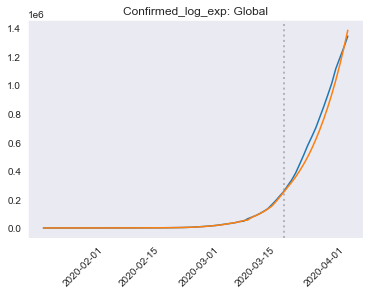

In [102]:
out = 0
try:
    print(diag_df_z.groupby('DF')['MAE','MSE','RMSE','R2'].mean(),"\n\n",
          pd.DataFrame(data=np.array(best_model.feature_importances_)*100,
                       columns=['Feature Importance'], index=columns[1:]
                      )\
            .sort_values(by='Feature Importance', ascending=False)
         )
except:
    print(diag_df_z.groupby('DF')['MAE','MSE','RMSE','R2'].mean())
    
    
# Plot ground truth
plt.plot(exp_df.loc[:,date_var],exp_df.loc[:,outputs_selected[out]+extra_str])
# Plot predictions
plt.plot(exp2_df.loc[:,date_var],exp2_df.loc[:,outputs_selected[out]+extra_str])
# Plot line separating train and test
plt.axvline(exp_df.loc[:,date_var][initial_split[0]-1], linewidth=2, ls = ':', color='grey', alpha=0.5)
plt.xticks(rotation=45)
plt.title(outputs_selected[out]+extra_str+': '+'Global')
plt.show()